## Package and setup

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from darts.models import RandomForestModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse, mae, r2_score
from darts.utils.utils import generate_index
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')


COLORS = {
    'IHSG': '#2E7D32',
    'IHSG_light': '#4CAF50',
    'IHSG_dark': '#1B5E20',    
    'Inflation': '#D32F2F',
    'BI_Rate': '#F57C00',        
    'M2_YoY': '#1976D2',         
    'USDIDR': '#7B1FA2',         
    'NPL_Ratio': '#C2185B',      
    'train': '#2E7D32',
    'actual': '#1976D2',
    'predicted': '#D32F2F',
    'error': '#9E9E9E',
    'split_line': '#616161',
}

COLOR_PALETTE = ['#2E7D32', '#D32F2F', '#F57C00', '#1976D2', '#7B1FA2', '#C2185B']

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100          # Display DPI
plt.rcParams['savefig.dpi'] = 300         # Export DPI (publication quality)
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1

# font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Georgia']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# line 
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 0.8

# grid
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linewidth'] = 0.5

# legend
plt.rcParams['legend.framealpha'] = 0.9
plt.rcParams['legend.edgecolor'] = '0.8'

The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.


## Data gathering and preprocessing

In [2]:
# data from bloomberg terminal
df = pd.read_csv('dataset/model1.csv')

# display basic info
print("="*60)
print("DATA OVERVIEW")
print("="*60)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumns: {df.columns.tolist()}")
print("\n" + "="*60)
print("FIRST 10 ROWS")
print("="*60)
df.head(10)

DATA OVERVIEW
Shape: 121 rows × 7 columns

Columns: ['Date', 'IHSG', 'Inflation Rate YoY', 'Money Supply M2 YoY', 'USDIDR', 'BI Interest Rate', 'npl_ratio']

FIRST 10 ROWS


,Date,IHSG,Inflation Rate YoY,Money Supply M2 YoY,USDIDR,BI Interest Rate,npl_ratio
0,31/01/2025,7109.196,0.76,5.46,16300,5.75%,2.18%
1,31/12/2024,7079.905,1.57,4.76,16102,6.00%,2.08%
2,30/11/2024,7114.266,1.55,6.53,15845,6.00%,2.19%
3,31/10/2024,7574.019,1.71,6.77,15697,6.00%,2.20%
4,30/09/2024,7527.929,1.84,7.19,15140,6.00%,2.21%
5,31/08/2024,7670.733,2.12,7.30,15455,6.25%,2.26%
6,31/07/2024,7255.762,2.13,7.59,16260,6.25%,2.27%
7,30/06/2024,7063.577,2.51,7.67,16375,6.25%,2.26%
8,31/05/2024,6970.736,2.84,7.59,16250,6.25%,2.34%
9,30/04/2024,7234.197,3.00,6.87,16260,6.25%,2.33%


In [3]:
# Check data types and missing values
print("="*60)
print("DATA TYPES & MISSING VALUES")
print("="*60)
df.info()
print("\n" + "="*60)
print("MISSING VALUES PER COLUMN")
print("="*60)
print(df.isnull().sum())

DATA TYPES & MISSING VALUES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 121 non-null    object 
 1   IHSG                 121 non-null    float64
 2   Inflation Rate YoY   121 non-null    float64
 3   Money Supply M2 YoY  121 non-null    float64
 4   USDIDR               121 non-null    int64  
 5   BI Interest Rate     121 non-null    object 
 6   npl_ratio            121 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 6.7+ KB

MISSING VALUES PER COLUMN
Date                   0
IHSG                   0
Inflation Rate YoY     0
Money Supply M2 YoY    0
USDIDR                 0
BI Interest Rate       0
npl_ratio              0
dtype: int64


In [4]:
df_clean = df.copy()

df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%d/%m/%Y')

pct_columns = ['BI Interest Rate', 'npl_ratio']
for col in pct_columns:
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].str.replace('%', '').astype(float)

df_clean = df_clean.sort_values('Date').reset_index(drop=True)

df_clean.columns = ['Date', 'IHSG', 'Inflation_YoY', 'M2_YoY', 'USDIDR', 'BI_Rate', 'NPL_Ratio']

print("="*60)
print("CLEANED DATA")
print("="*60)
print(f"Date Range: {df_clean['Date'].min()} to {df_clean['Date'].max()}")
print(f"Total Months: {len(df_clean)}")
print("\nData Types after cleaning:")
print(df_clean.dtypes)
print("\n")
df_clean.head(10)

CLEANED DATA
Date Range: 2015-01-31 00:00:00 to 2025-01-31 00:00:00
Total Months: 121

Data Types after cleaning:
Date             datetime64[ns]
IHSG                    float64
Inflation_YoY           float64
M2_YoY                  float64
USDIDR                    int64
BI_Rate                 float64
NPL_Ratio               float64
dtype: object




,Date,IHSG,Inflation_YoY,M2_YoY,USDIDR,BI_Rate,NPL_Ratio
0,2015-01-31,5289.404,6.96,14.31,12755,7.75,2.37
1,2015-02-28,5450.294,6.29,16.04,12928,7.50,2.43
2,2015-03-31,5518.675,6.38,16.26,13075,7.50,2.40
3,2015-04-30,5086.425,6.79,14.88,12964,7.50,2.48
4,2015-05-31,5216.379,7.15,13.42,13225,7.50,2.58
5,2015-06-30,4910.658,7.26,12.98,13333,7.50,2.56
6,2015-07-31,4802.529,7.26,12.50,13531,7.50,2.70
7,2015-08-31,4509.607,7.18,13.32,14053,7.50,2.76
8,2015-09-30,4223.908,6.83,12.43,14651,7.50,2.71
9,2015-10-31,4455.180,6.25,10.40,13695,7.50,2.68


In [5]:
# Descriptive statistics
print("="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)
df_clean.describe().round(2)

DESCRIPTIVE STATISTICS


,Date,IHSG,Inflation_YoY,M2_YoY,USDIDR,BI_Rate,NPL_Ratio
count,121,121.00,121.00,121.00,121.00,121.00,121.00
mean,2020-01-30 02:58:30.743801600,6077.38,3.36,8.81,14363.80,5.25,2.77
min,2015-01-31 00:00:00,4223.91,0.76,3.35,12755.00,3.50,2.08
25%,2017-07-31 00:00:00,5386.69,2.48,6.77,13655.00,4.25,2.52
50%,2020-01-31 00:00:00,6056.12,3.18,8.18,14273.00,5.25,2.76
75%,2022-07-31 00:00:00,6843.24,3.83,10.53,14903.00,6.00,3.05
max,2025-01-31 00:00:00,7670.73,7.26,16.26,16375.00,7.75,3.35
std,NaN,850.61,1.49,2.74,895.79,1.24,0.32


## 4. Exploratory Data Analysis (EDA)

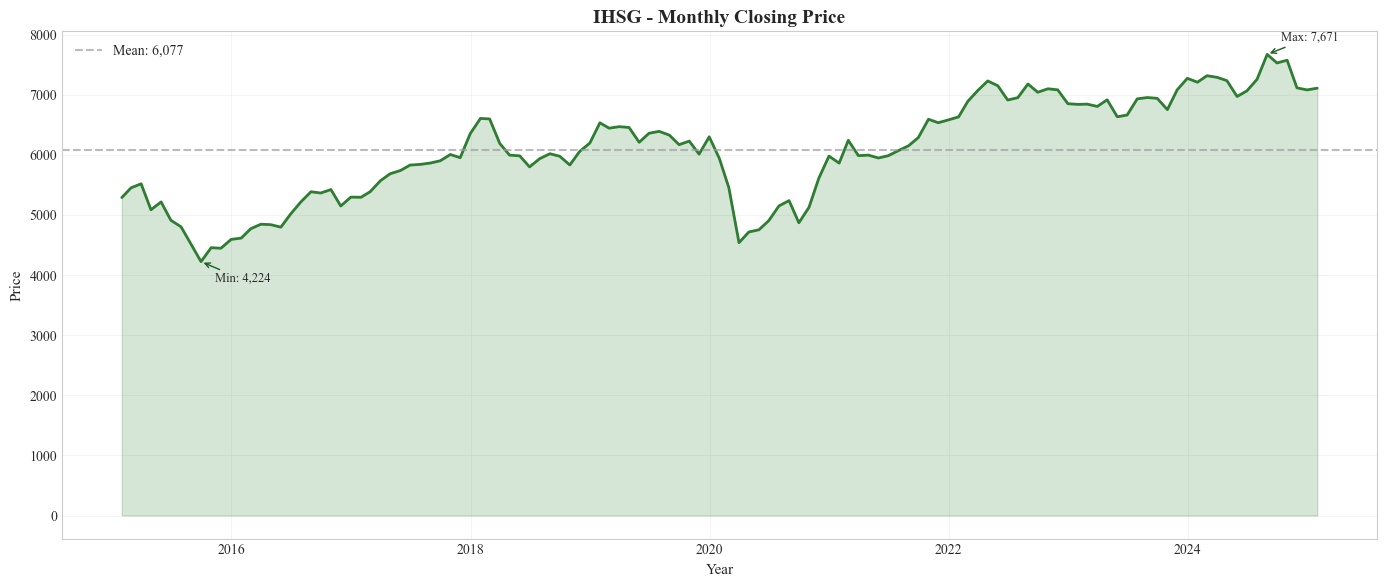

In [6]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df_clean['Date'], df_clean['IHSG'], color=COLORS['IHSG'], linewidth=2)
ax.fill_between(df_clean['Date'], df_clean['IHSG'], alpha=0.2, color=COLORS['IHSG'])

# Add mean line
ihsg_mean = df_clean['IHSG'].mean()
ax.axhline(y=ihsg_mean, color=COLORS['error'], linestyle='--', alpha=0.7, 
           label=f'Mean: {ihsg_mean:,.0f}')

ax.set_title('IHSG - Monthly Closing Price', fontsize=14, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Price')
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3)

# Add annotations for min/max
ihsg_max_idx = df_clean['IHSG'].idxmax()
ihsg_min_idx = df_clean['IHSG'].idxmin()
ax.annotate(f"Max: {df_clean.loc[ihsg_max_idx, 'IHSG']:,.0f}", 
            xy=(df_clean.loc[ihsg_max_idx, 'Date'], df_clean.loc[ihsg_max_idx, 'IHSG']),
            xytext=(10, 10), textcoords='offset points', fontsize=9,
            arrowprops=dict(arrowstyle='->', color=COLORS['IHSG_dark']))
ax.annotate(f"Min: {df_clean.loc[ihsg_min_idx, 'IHSG']:,.0f}", 
            xy=(df_clean.loc[ihsg_min_idx, 'Date'], df_clean.loc[ihsg_min_idx, 'IHSG']),
            xytext=(10, -15), textcoords='offset points', fontsize=9,
            arrowprops=dict(arrowstyle='->', color=COLORS['IHSG_dark']))

plt.tight_layout()
plt.savefig('model1-figure/eda_ihsg.png', dpi=300, bbox_inches='tight')
plt.show()

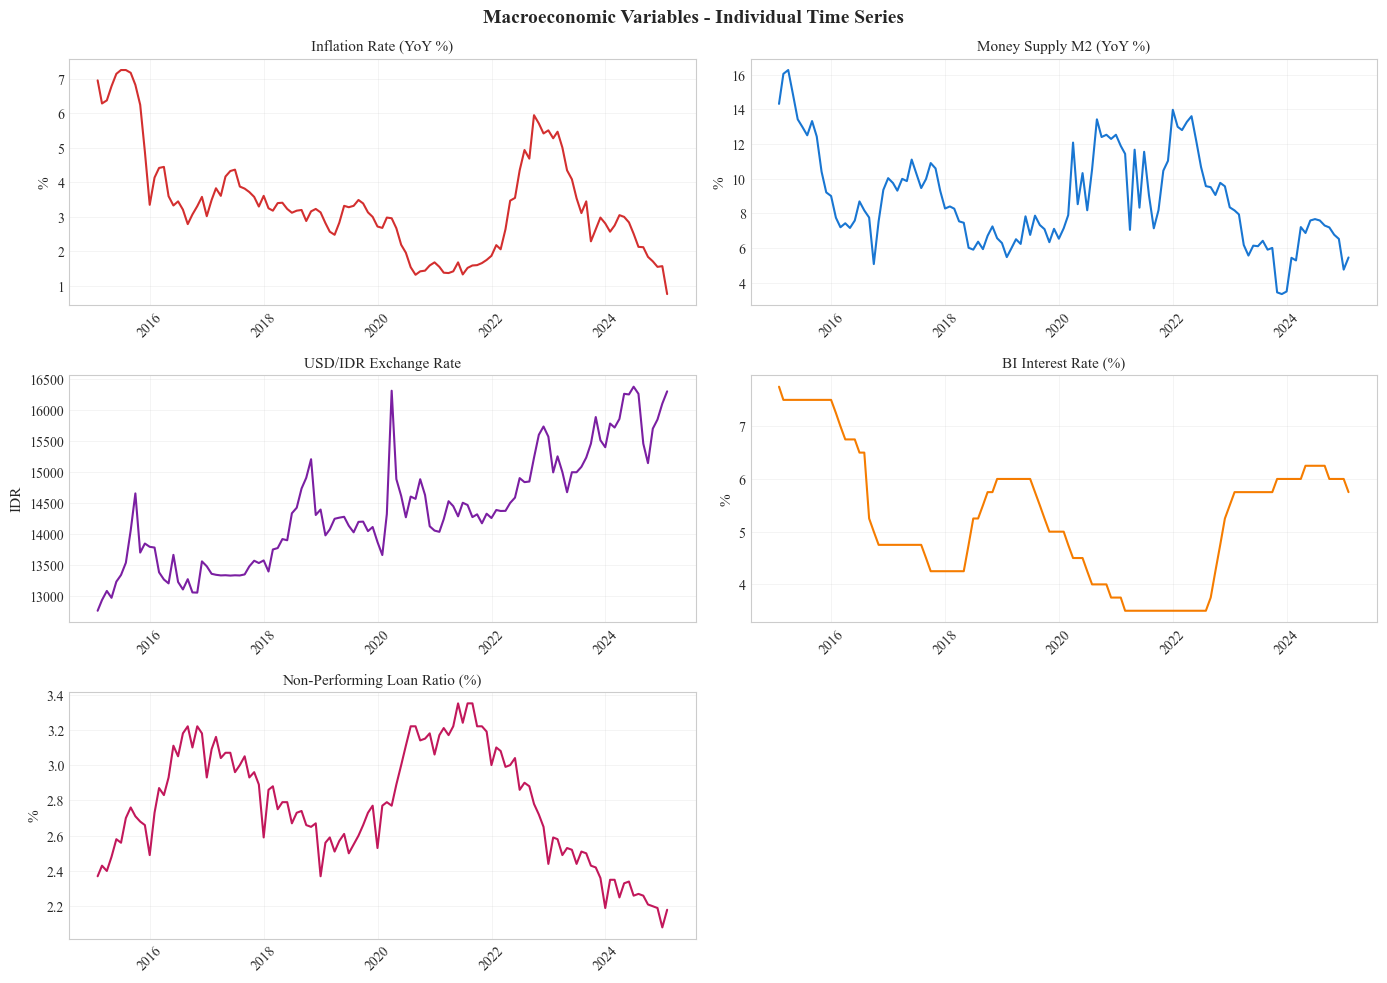

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Macroeconomic Variables - Individual Time Series', fontsize=14, fontweight='bold')

plot_config = [
    ('Inflation_YoY', COLORS['Inflation'], 'Inflation Rate (YoY %)', '%'),
    ('M2_YoY', COLORS['M2_YoY'], 'Money Supply M2 (YoY %)', '%'),
    ('USDIDR', COLORS['USDIDR'], 'USD/IDR Exchange Rate', 'IDR'),
    ('BI_Rate', COLORS['BI_Rate'], 'BI Interest Rate (%)', '%'),
    ('NPL_Ratio', COLORS['NPL_Ratio'], 'Non-Performing Loan Ratio (%)', '%'),
]

for idx, (col, color, title, ylabel) in enumerate(plot_config):
    ax = axes[idx // 2, idx % 2]
    ax.plot(df_clean['Date'], df_clean[col], color=color, linewidth=1.5)
    ax.set_title(title, fontsize=11)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

# Hide the last empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.savefig('model1-figure/eda_covariates_individual.png', dpi=300, bbox_inches='tight')
plt.show()

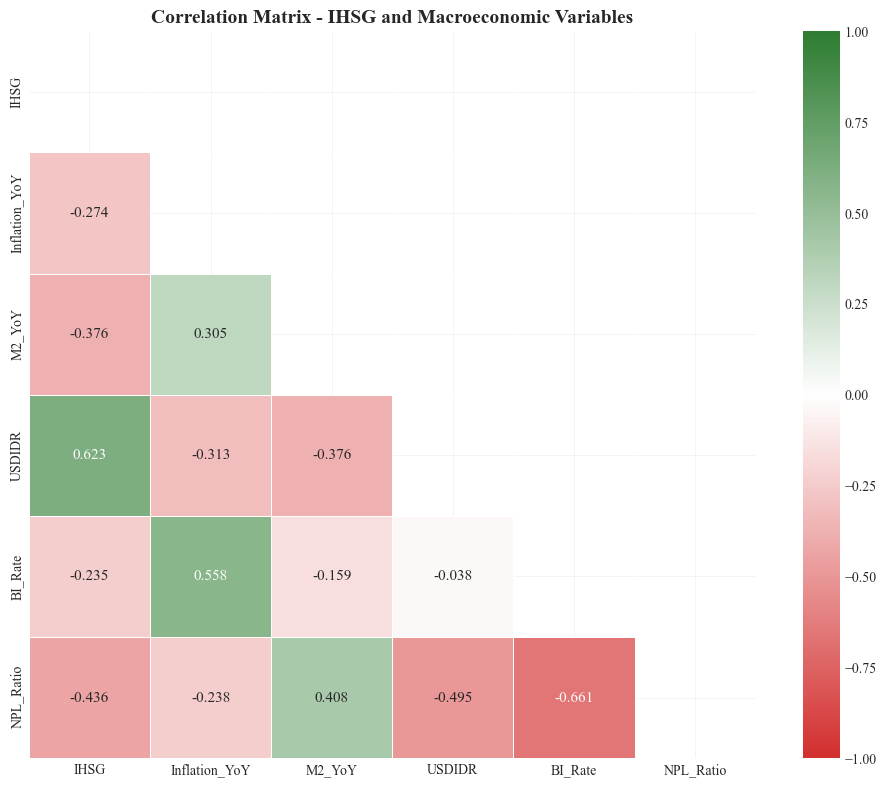

✅ Figure saved: model1-figure/correlation_matrix.png (300 DPI)

CORRELATION WITH IHSG
USDIDR          : +0.6227 (Moderate ↑ Positive)
BI_Rate         : -0.2353 (Weak ↓ Negative)
Inflation_YoY   : -0.2740 (Weak ↓ Negative)
M2_YoY          : -0.3763 (Weak ↓ Negative)
NPL_Ratio       : -0.4360 (Moderate ↓ Negative)


In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

corr_matrix = df_clean.drop('Date', axis=1).corr()

# Custom colormap: Green (positive with IHSG) to Red (negative)
from matplotlib.colors import LinearSegmentedColormap
colors_cmap = ['#D32F2F', '#FFFFFF', '#2E7D32']  # Red - White - Green
custom_cmap = LinearSegmentedColormap.from_list('thesis_cmap', colors_cmap, N=256)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap=custom_cmap, 
            center=0, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 11}, vmin=-1, vmax=1)

ax.set_title('Correlation Matrix - IHSG and Macroeconomic Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model1-figure/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figure saved: model1-figure/correlation_matrix.png (300 DPI)")
print("\n" + "="*60)
print("CORRELATION WITH IHSG")
print("="*60)
ihsg_corr = corr_matrix['IHSG'].drop('IHSG').sort_values(ascending=False)
for var, corr in ihsg_corr.items():
    direction = "↑ Positive" if corr > 0 else "↓ Negative"
    strength = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.4 else "Weak"
    print(f"{var:15} : {corr:+.4f} ({strength} {direction})")

## 5. Create Darts TimeSeries Objects

In [9]:
IHSG_series = TimeSeries.from_dataframe(df_clean, time_col='Date', value_cols='IHSG', freq='ME')
COVAR_series = TimeSeries.from_dataframe(df_clean, time_col='Date', value_cols=['Inflation_YoY', 'M2_YoY', 'USDIDR', 'BI_Rate', 'NPL_Ratio'], freq='ME')

In [10]:
train_ratio = 0.8
split_point = int(len(IHSG_series) * train_ratio)

ihsg_train = IHSG_series[:split_point]
ihsg_test = IHSG_series[split_point:]

covar_train = COVAR_series[:split_point]
covar_test = COVAR_series[split_point:]

<Axes: xlabel='Date'>

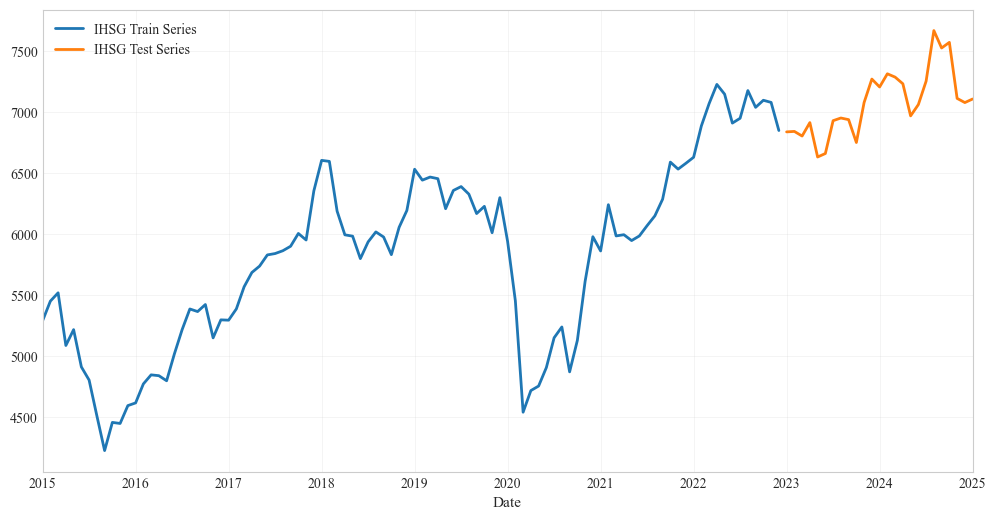

In [11]:
ihsg_train.plot(label='IHSG Train Series')
ihsg_test.plot(label='IHSG Test Series')

In [12]:
ihsg_train

,IHSG
Date,
2015-01-31,5289.404
2015-02-28,5450.294
2015-03-31,5518.675
2015-04-30,5086.425
2015-05-31,5216.379
...,...
2022-08-31,7178.590
2022-09-30,7040.798
2022-10-31,7098.890


In [13]:
print("DARTS TIMESERIES")
print("="*60)
print(f"Target Series (IHSG):")
print(f"  - Start: {IHSG_series.start_time()}")
print(f"  - End: {IHSG_series.end_time()}")
print(f"  - Length: {len(IHSG_series)} time steps")
print(f"  - Frequency: {IHSG_series.freq}")
print(f"\nCovariates:")
print(f"  - Components: {COVAR_series.components.tolist()}")
print(f"  - Length: {len(COVAR_series)} time steps")

DARTS TIMESERIES
Target Series (IHSG):
  - Start: 2015-01-31 00:00:00
  - End: 2025-01-31 00:00:00
  - Length: 121 time steps
  - Frequency: <MonthEnd>

Covariates:
  - Components: ['Inflation_YoY', 'M2_YoY', 'USDIDR', 'BI_Rate', 'NPL_Ratio']
  - Length: 121 time steps


## train, test, split and normalization

In [14]:
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler

# Scaler untuk IHSG
scaler_ihsg = Scaler(MinMaxScaler(feature_range=(-1, 1)))
ihsg_train_scaled = scaler_ihsg.fit_transform(ihsg_train)
ihsg_test_scaled = scaler_ihsg.transform(ihsg_test)

# Scaler untuk Covariates
scaler_covar = Scaler(MinMaxScaler(feature_range=(-1, 1)))
covar_train_scaled = scaler_covar.fit_transform(covar_train)
covar_test_scaled = scaler_covar.transform(covar_test)

# Gabungkan covariates untuk prediksi (train + test)
covar_full_scaled = covar_train_scaled.append(covar_test_scaled)

# =====================================================
# VERIFIKASI TIDAK ADA LEAKAGE
# =====================================================
print("\n" + "="*60)
print("DATA LEAKAGE CHECK")
print("="*60)
print(f"Train Target: {ihsg_train_scaled.start_time()} → {ihsg_train_scaled.end_time()}")
print(f"Train Cov:    {covar_train_scaled.start_time()} → {covar_train_scaled.end_time()}")
print(f"Test Target:  {ihsg_test_scaled.start_time()} → {ihsg_test_scaled.end_time()}")
print(f"Test Cov:     {covar_test_scaled.start_time()} → {covar_test_scaled.end_time()}")

assert ihsg_train_scaled.end_time() == covar_train_scaled.end_time(), \
    "ERROR: Train target dan covariates tidak sinkron!"
print("\n✓ No data leakage detected in split")


DATA LEAKAGE CHECK
Train Target: 2015-01-31 00:00:00 → 2022-12-31 00:00:00
Train Cov:    2015-01-31 00:00:00 → 2022-12-31 00:00:00
Test Target:  2023-01-31 00:00:00 → 2025-01-31 00:00:00
Test Cov:     2023-01-31 00:00:00 → 2025-01-31 00:00:00

✓ No data leakage detected in split


## hyperparameter tuning

In [15]:
from darts.models import RandomForestModel
from darts.metrics import mape

OUTPUT_CHUNK_LENGTH = 1


param_grid = {
    'lags': [1, 3, 6, 12],
    'lags_past_covariates': [1, 3, 6, 12],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True]
}

print("\n" + "="*60)
print("GRIDSEARCH CONFIGURATION")
print("="*60)
print(f"Output Chunk Length (Horizon): {OUTPUT_CHUNK_LENGTH}")
print("\nHyperparameter Grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal combinations: {total_combinations}")
print(f"Random samples: 200")
print(f"Estimated time: ~{total_combinations * 2 / 60:.1f} minutes (rough estimate)")


GRIDSEARCH CONFIGURATION
Output Chunk Length (Horizon): 1

Hyperparameter Grid:
  lags: [1, 3, 6, 12]
  lags_past_covariates: [1, 3, 6, 12]
  n_estimators: [100, 200, 300]
  max_depth: [3, 5, 7, None]
  max_features: ['sqrt', 'log2']
  min_samples_split: [2, 4]
  min_samples_leaf: [2, 4]
  bootstrap: [True]

Total combinations: 1536
Random samples: 200
Estimated time: ~51.2 minutes (rough estimate)


In [16]:
print("\n" + "="*60)
print("RUNNING GRIDSEARCH...")
print("="*60)

best_model, best_params, best_score = RandomForestModel.gridsearch(
    parameters=param_grid,
    series=ihsg_train_scaled,
    past_covariates=covar_full_scaled,
    val_series=ihsg_test_scaled,
    metric=mape,
    verbose=True,
    n_jobs=-1,
    n_random_samples=200  # random search untuk efisiensi
)

print("\n" + "="*60)
print("GRIDSEARCH RESULTS")
print("="*60)
print(f"Best MAPE Score: {best_score:.4f}%")
print(f"\nBest Hyperparameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Save best params untuk reproduksi
import json
with open('best_params_monthly_rf.json', 'w') as f:
    json.dump(best_params, f, indent=2)
print("\n✓ Best parameters saved to 'best_params_monthly_rf.json'")


RUNNING GRIDSEARCH...


gridsearch:   0%|          | 0/200 [00:00<?, ?it/s]


GRIDSEARCH RESULTS
Best MAPE Score: 16.5785%

Best Hyperparameters:
  lags: 12
  lags_past_covariates: 1
  n_estimators: 100
  max_depth: 3
  max_features: log2
  min_samples_split: 4
  min_samples_leaf: 2
  bootstrap: True

✓ Best parameters saved to 'best_params_monthly_rf.json'


In [17]:
final_model = RandomForestModel(
    lags=best_params['lags'],
    lags_past_covariates=best_params['lags_past_covariates'],
    output_chunk_length=OUTPUT_CHUNK_LENGTH,
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    bootstrap=best_params['bootstrap'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    n_jobs=-1
)

final_model.fit(
    series=ihsg_train_scaled,
    past_covariates=covar_full_scaled,
    verbose=True
)

RandomForestModel(lags=12, lags_past_covariates=1, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, n_estimators=100, max_depth=3, multi_models=True, use_static_covariates=True, random_state=42, max_features=log2, bootstrap=True, min_samples_split=4, min_samples_leaf=2, n_jobs=-1)

In [18]:
print("\n" + "="*60)
print("ROLLING FORECAST EVALUATION")
print("="*60)

# =====================================================
# STRATEGI 1: ROLLING FORECAST (REALISTIS)
# =====================================================
predictions_scaled = []
test_length = len(ihsg_test_scaled)

print(f"Forecasting {test_length} steps ahead using rolling window...")

for i in range(test_length):
    # Historical data untuk forecast: train + actual test sampai i
    historical_target = ihsg_train_scaled.append(ihsg_test_scaled[:i]) if i > 0 else ihsg_train_scaled
    
    # Predict 1 step ahead
    pred_scaled = final_model.predict(
        n=1,
        series=historical_target,
        past_covariates=covar_full_scaled
    )
    
    predictions_scaled.append(pred_scaled)
    
    # Progress indicator
    if (i + 1) % 6 == 0 or (i + 1) == test_length:
        print(f"  Progress: {i+1}/{test_length} forecasts completed")

# Concatenate all predictions
from darts import concatenate
forecast_scaled = concatenate(predictions_scaled, axis=0)

print("\n✓ Rolling forecast completed")
print(f"Forecast period: {forecast_scaled.start_time()} → {forecast_scaled.end_time()}")


ROLLING FORECAST EVALUATION
Forecasting 25 steps ahead using rolling window...
  Progress: 6/25 forecasts completed
  Progress: 12/25 forecasts completed
  Progress: 18/25 forecasts completed
  Progress: 24/25 forecasts completed
  Progress: 25/25 forecasts completed

✓ Rolling forecast completed
Forecast period: 2023-01-31 00:00:00 → 2025-01-31 00:00:00


In [19]:
# =====================================================
# INVERSE TRANSFORM KE SKALA ASLI
# =====================================================
forecast_original = scaler_ihsg.inverse_transform(forecast_scaled)
ihsg_test_original = scaler_ihsg.inverse_transform(ihsg_test_scaled)

print("\n" + "="*60)
print("MODEL EVALUATION METRICS")
print("="*60)

from darts.metrics import mae, rmse, mape, mse, r2_score
import numpy as np

# Calculate metrics
mae_score = mae(ihsg_test_original, forecast_original)
rmse_score = rmse(ihsg_test_original, forecast_original)
mape_score = mape(ihsg_test_original, forecast_original)
mse_score = mse(ihsg_test_original, forecast_original)
r2 = r2_score(ihsg_test_original, forecast_original)

# Directional accuracy
actual_direction = np.sign(np.diff(ihsg_test_original.values().flatten()))
pred_direction = np.sign(np.diff(forecast_original.values().flatten()))
directional_accuracy = np.mean(actual_direction == pred_direction) * 100

print(f"MAE:   {mae_score:.2f}")
print(f"RMSE:  {rmse_score:.2f}")
print(f"MAPE:  {mape_score:.2f}%")
print(f"MSE:   {mse_score:.2f}")
print(f"R²:    {r2:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")

# Error statistics
errors = ihsg_test_original.values().flatten() - forecast_original.values().flatten()
print(f"\nError Statistics:")
print(f"  Mean Error: {np.mean(errors):.2f}")
print(f"  Std Error:  {np.std(errors):.2f}")
print(f"  Min Error:  {np.min(errors):.2f}")
print(f"  Max Error:  {np.max(errors):.2f}")


MODEL EVALUATION METRICS
MAE:   243.73
RMSE:  307.46
MAPE:  3.38%
MSE:   94532.88
R²:    -0.3341
Directional Accuracy: 62.50%

Error Statistics:
  Mean Error: 137.67
  Std Error:  274.92
  Min Error:  -343.48
  Max Error:  735.52



GENERATING VISUALIZATIONS
✓ Saved: rf_monthly_rolling_forecast.png


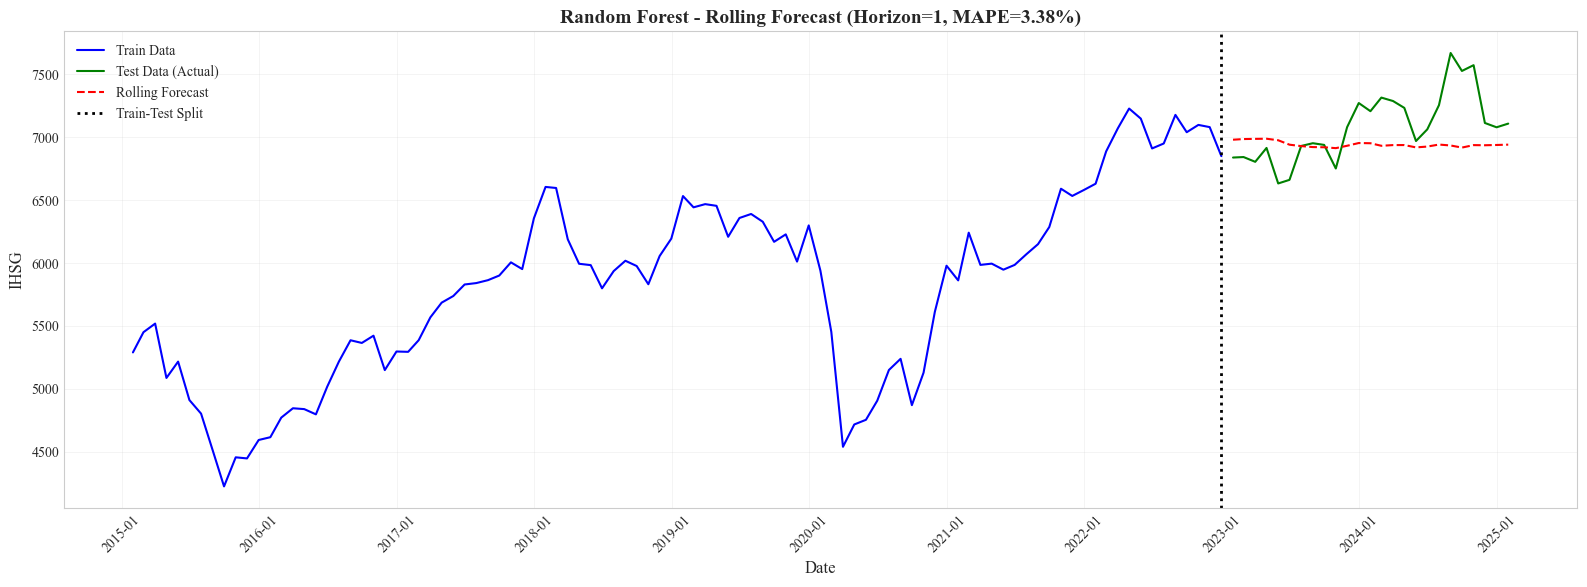

✓ Saved: rf_monthly_test_detail.png


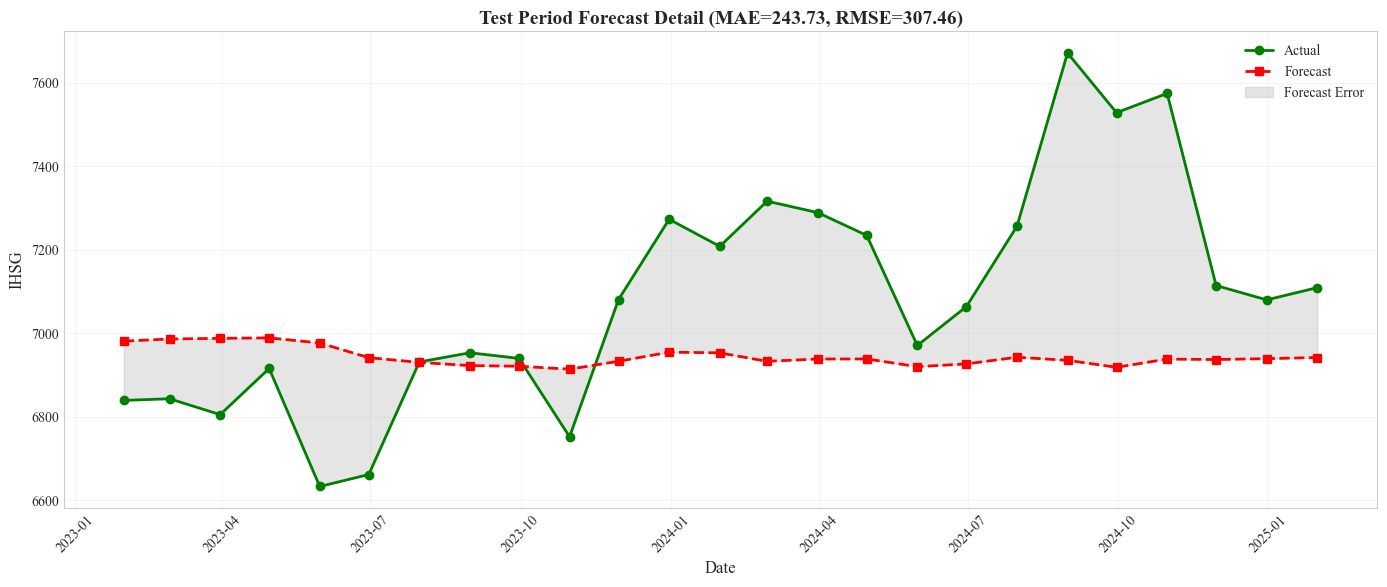

✓ Saved: rf_monthly_residual_analysis.png


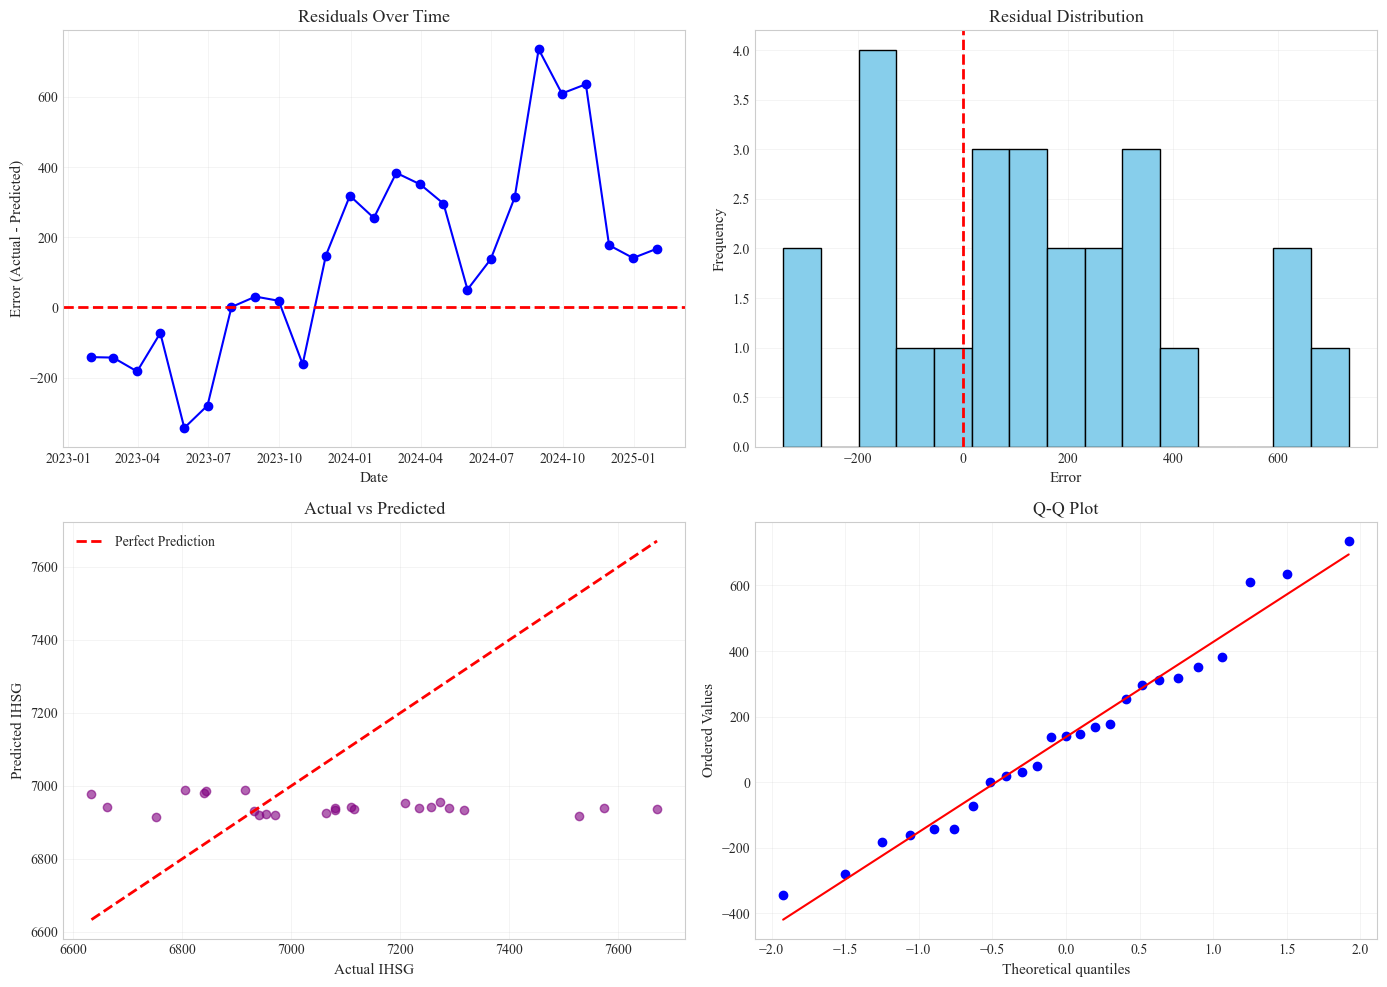


✓ All visualizations completed


In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

# =====================================================
# PLOT 1: FULL TIME SERIES WITH PREDICTIONS
# =====================================================
fig, ax = plt.subplots(figsize=(16, 6))

# Plot train
ihsg_train_original = scaler_ihsg.inverse_transform(ihsg_train_scaled)
ax.plot(ihsg_train_original.time_index, 
        ihsg_train_original.values().flatten(),
        label='Train Data', color='blue', linewidth=1.5)

# Plot test (actual)
ax.plot(ihsg_test_original.time_index, 
        ihsg_test_original.values().flatten(),
        label='Test Data (Actual)', color='green', linewidth=1.5)

# Plot predictions
ax.plot(forecast_original.time_index, 
        forecast_original.values().flatten(),
        label='Rolling Forecast', color='red', linewidth=1.5, linestyle='--')

# Add vertical line at split point
split_date = ihsg_train_original.end_time()
ax.axvline(x=split_date, color='black', linestyle=':', linewidth=2, label='Train-Test Split')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('IHSG', fontsize=12)
ax.set_title(f'Random Forest - Rolling Forecast (Horizon=1, MAPE={mape_score:.2f}%)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('rf_monthly_rolling_forecast.png', dpi=300, bbox_inches='tight')
print("✓ Saved: rf_monthly_rolling_forecast.png")
plt.show()

# =====================================================
# PLOT 2: ZOOM IN PADA TEST PERIOD
# =====================================================
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(ihsg_test_original.time_index, 
        ihsg_test_original.values().flatten(),
        label='Actual', color='green', linewidth=2, marker='o')

ax.plot(forecast_original.time_index, 
        forecast_original.values().flatten(),
        label='Forecast', color='red', linewidth=2, marker='s', linestyle='--')

ax.fill_between(ihsg_test_original.time_index,
                ihsg_test_original.values().flatten(),
                forecast_original.values().flatten(),
                alpha=0.2, color='gray', label='Forecast Error')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('IHSG', fontsize=12)
ax.set_title(f'Test Period Forecast Detail (MAE={mae_score:.2f}, RMSE={rmse_score:.2f})', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('rf_monthly_test_detail.png', dpi=300, bbox_inches='tight')
print("✓ Saved: rf_monthly_test_detail.png")
plt.show()

# =====================================================
# PLOT 3: RESIDUAL ANALYSIS
# =====================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals over time
axes[0, 0].plot(ihsg_test_original.time_index, errors, color='blue', marker='o')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Residuals Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Error (Actual - Predicted)')
axes[0, 0].grid(True, alpha=0.3)

# Residual histogram
axes[0, 1].hist(errors, bins=15, color='skyblue', edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Residual Distribution')
axes[0, 1].set_xlabel('Error')
axes[0, 1].set_ylabel('Frequency')

# Actual vs Predicted scatter
axes[1, 0].scatter(ihsg_test_original.values().flatten(), 
                   forecast_original.values().flatten(), 
                   alpha=0.6, color='purple')
axes[1, 0].plot([ihsg_test_original.values().min(), ihsg_test_original.values().max()],
                [ihsg_test_original.values().min(), ihsg_test_original.values().max()],
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title('Actual vs Predicted')
axes[1, 0].set_xlabel('Actual IHSG')
axes[1, 0].set_ylabel('Predicted IHSG')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# QQ plot
from scipy import stats
stats.probplot(errors, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rf_monthly_residual_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: rf_monthly_residual_analysis.png")
plt.show()

print("\n✓ All visualizations completed")

In [21]:
# =====================================================
# SAVE RESULTS
# =====================================================
print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

# Save predictions to CSV
import pandas as pd

results_df = pd.DataFrame({
    'Date': ihsg_test_original.time_index,
    'Actual': ihsg_test_original.values().flatten(),
    'Predicted': forecast_original.values().flatten(),
    'Error': errors,
    'Absolute_Error': np.abs(errors),
    'Percentage_Error': (errors / ihsg_test_original.values().flatten()) * 100
})

results_df.to_csv('rf_monthly_rolling_forecast_results.csv', index=False)
print("✓ Saved: rf_monthly_rolling_forecast_results.csv")

# Save model
final_model.save('rf_monthly_model.pkl')
print("✓ Saved: rf_monthly_model.pkl")

# Save evaluation metrics
metrics_dict = {
    'model': 'RandomForest',
    'frequency': 'Monthly',
    'horizon': OUTPUT_CHUNK_LENGTH,
    'train_size': len(ihsg_train),
    'test_size': len(ihsg_test),
    'best_lags': best_params['lags'],
    'best_lags_past_covariates': best_params['lags_past_covariates'],
    'MAE': float(mae_score),
    'RMSE': float(rmse_score),
    'MAPE': float(mape_score),
    'MSE': float(mse_score),
    'R2': float(r2),
    'Directional_Accuracy': float(directional_accuracy)
}

with open('rf_monthly_metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=2)
print("✓ Saved: rf_monthly_metrics.json")

print("\n" + "="*60)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("="*60)


SAVING RESULTS
✓ Saved: rf_monthly_rolling_forecast_results.csv
✓ Saved: rf_monthly_model.pkl
✓ Saved: rf_monthly_metrics.json

PIPELINE COMPLETED SUCCESSFULLY!



SHAP EXPLAINABILITY ANALYSIS

Initializing SHAP Explainer...
✓ SHAP Explainer initialized
  Background samples: 50
  Method: TreeExplainer (optimized for Random Forest)
  Best lags (target): 12
  Best lags (covariates): 1

GENERATING SHAP EXPLANATIONS FOR TEST DATA
✓ SHAP explanations generated successfully

EXTRACTING SHAP VALUES FOR ANALYSIS
SHAP values shape: (14, 17)
Feature values shape: (14, 17)
Total features: 17
Available timestamps: 14
SHAP date range: Jan 2023 to Feb 2024

GENERATING SHAP SUMMARY PLOTS


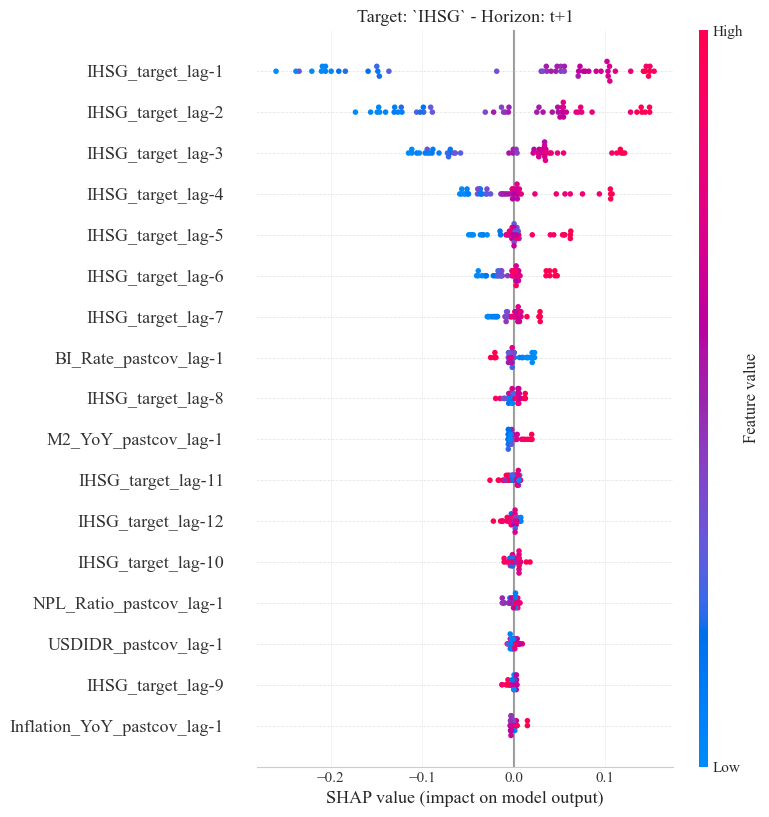

✓ Saved: shap_summary_dot.png


<Figure size 1200x600 with 0 Axes>

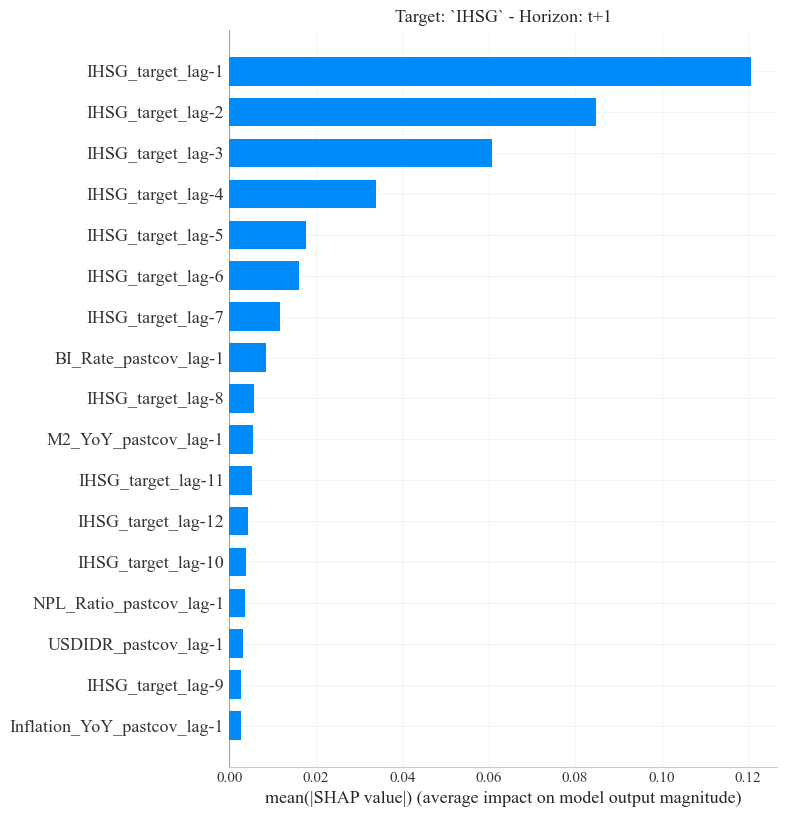

✓ Saved: shap_summary_bar.png


<Figure size 1200x600 with 0 Axes>


CALCULATING FEATURE IMPORTANCE METRICS

TOP 20 MOST IMPORTANT FEATURES (by Mean |SHAP|)
----------------------------------------------------------------------
                    Feature  Mean_Abs_SHAP  Mean_SHAP     Std_SHAP  Max_Abs_SHAP
          IHSG_target_lag-1       0.152596   0.152596 8.993493e-04      0.154123
          IHSG_target_lag-2       0.147971   0.147971 2.734804e-03      0.154027
          IHSG_target_lag-3       0.117131   0.117131 1.006763e-03      0.118585
          IHSG_target_lag-4       0.104546   0.104546 9.430783e-04      0.105836
          IHSG_target_lag-5       0.063292   0.063292 8.715255e-04      0.064616
          IHSG_target_lag-6       0.044576   0.044576 7.835351e-04      0.046543
          IHSG_target_lag-7       0.027299   0.027299 2.276062e-04      0.027808
         IHSG_target_lag-10       0.017235   0.017235 3.469447e-18      0.017235
          IHSG_target_lag-8       0.011159   0.011159 2.858271e-04      0.011592
      BI_Rate_pastcov_lag-1   

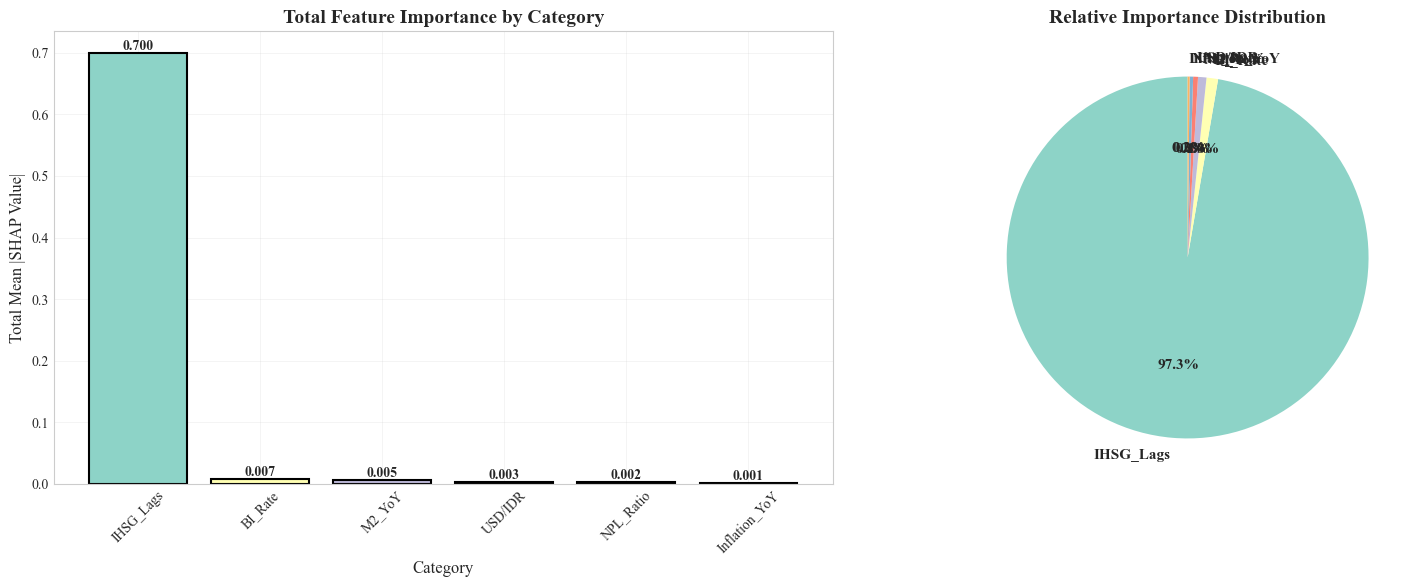


VISUALIZING TOP FEATURES
✓ Saved: shap_top_features.png


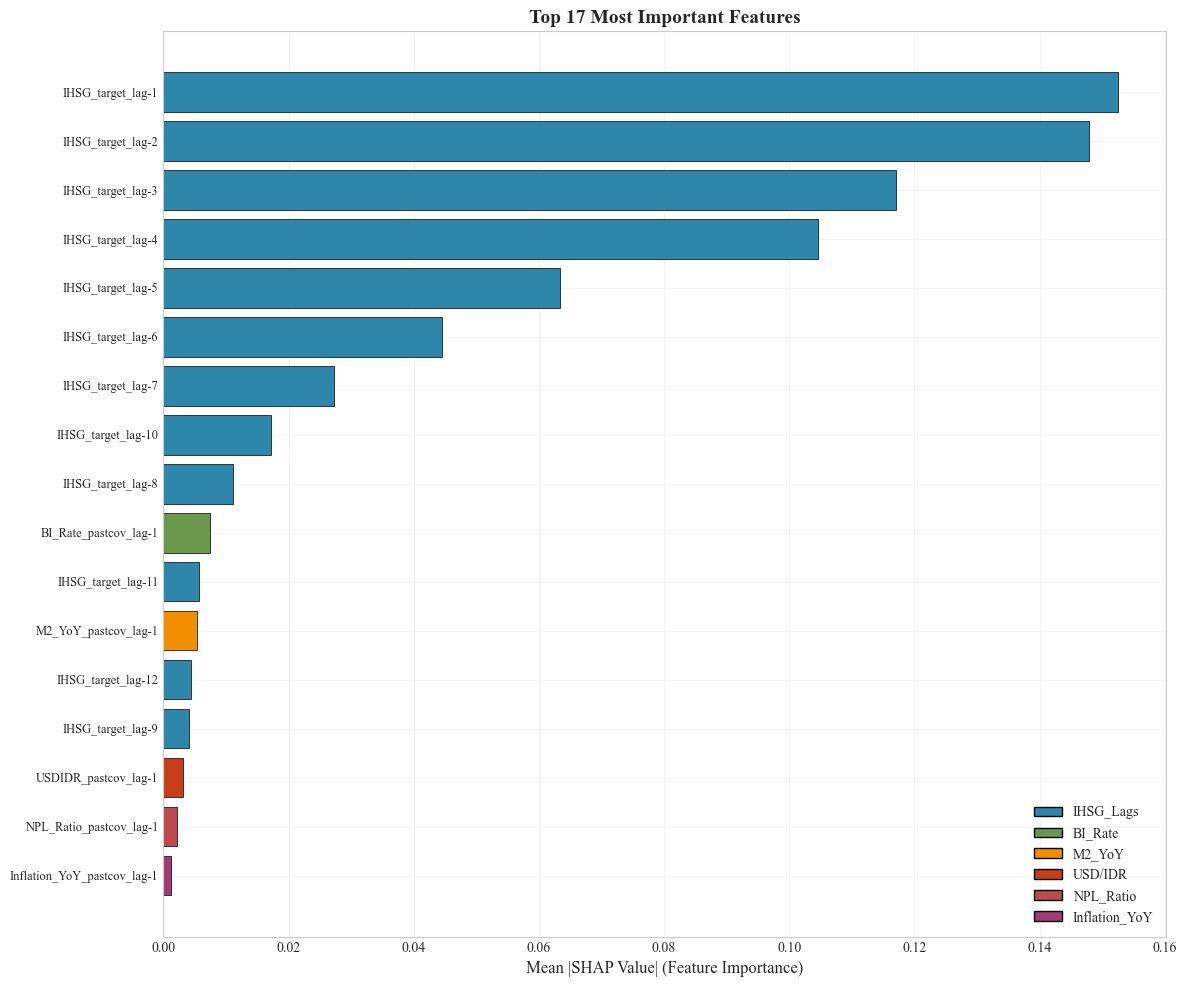


ANALYZING SHAP VALUES OVER TIME
✓ Saved: shap_temporal_analysis.png


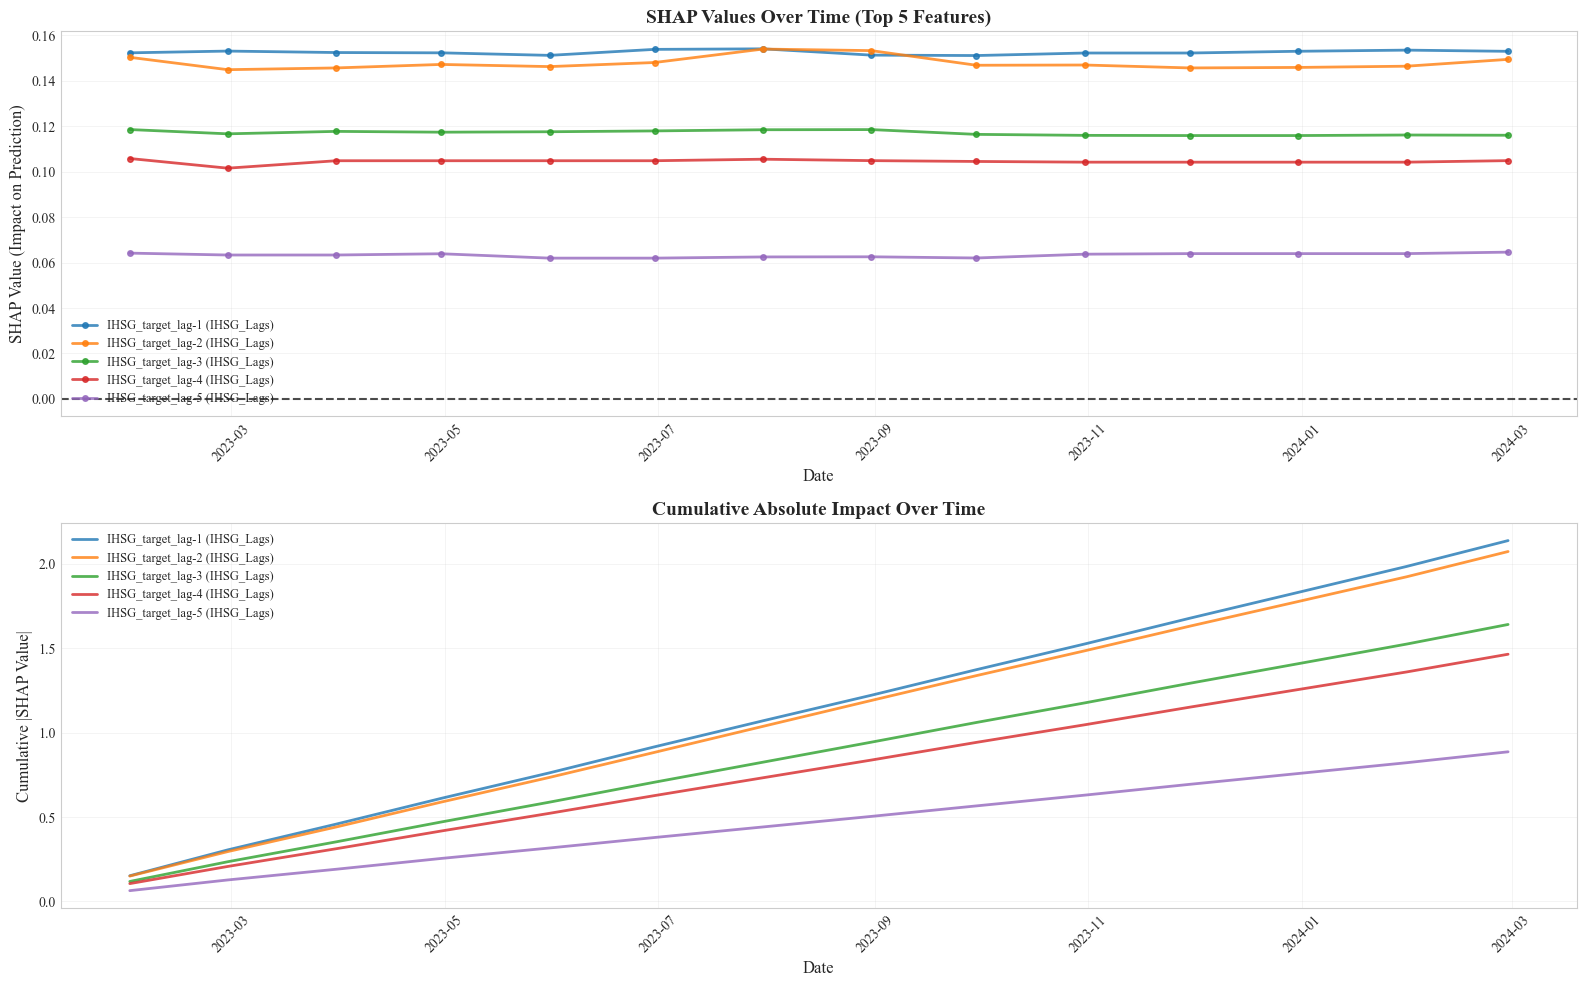


DETAILED STATISTICS BY COVARIATE TYPE

IHSG_Lags:
  Total importance:     0.7000
  Number of features:   12
  Mean per feature:     0.0583
  Std per feature:      0.0574
  Top 3 features:
    - IHSG_target_lag-1                             : 0.1526 (mean=+0.1526, std=0.0009)
    - IHSG_target_lag-2                             : 0.1480 (mean=+0.1480, std=0.0027)
    - IHSG_target_lag-3                             : 0.1171 (mean=+0.1171, std=0.0010)

BI_Rate:
  Total importance:     0.0074
  Number of features:   1
  Mean per feature:     0.0074
  Std per feature:      nan
  Top 3 features:
    - BI_Rate_pastcov_lag-1                         : 0.0074 (mean=-0.0074, std=0.0047)

M2_YoY:
  Total importance:     0.0054
  Number of features:   1
  Mean per feature:     0.0054
  Std per feature:      nan
  Top 3 features:
    - M2_YoY_pastcov_lag-1                          : 0.0054 (mean=-0.0054, std=0.0005)

USD/IDR:
  Total importance:     0.0031
  Number of features:   1
  Mean per featur

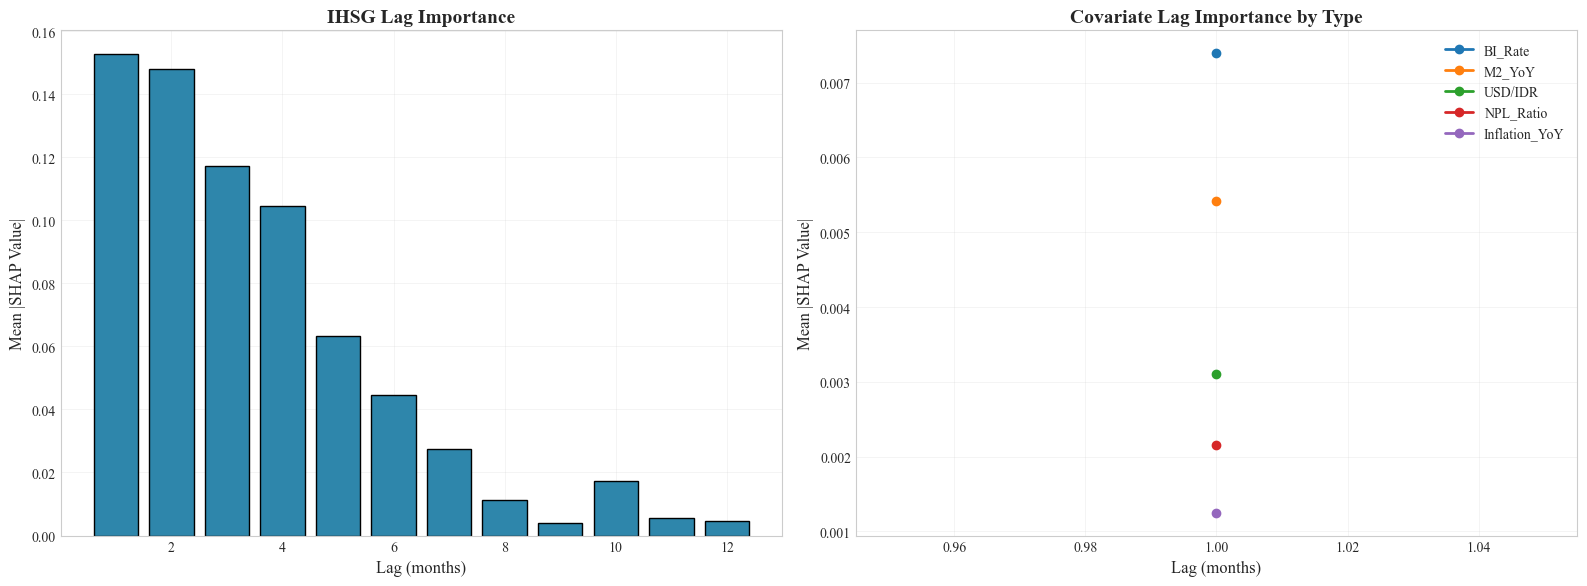


POSITIVE VS NEGATIVE IMPACT ANALYSIS

Features with POSITIVE bias (push predictions UP):
  M2_YoY_pastcov_lag-1                         : +2.1363
  IHSG_target_lag-11                           : +2.0716
  BI_Rate_pastcov_lag-1                        : +1.6398
  IHSG_target_lag-8                            : +1.4636
  IHSG_target_lag-10                           : +0.8861

Features with NEGATIVE bias (push predictions DOWN):
  NPL_Ratio_pastcov_lag-1                      : -0.1035
  IHSG_target_lag-2                            : -0.0794
  IHSG_target_lag-9                            : -0.0758
  IHSG_target_lag-1                            : -0.0623
  IHSG_target_lag-4                            : -0.0569

SAVING RESULTS FOR THESIS
✓ shap_feature_importance_detailed.csv
✓ shap_category_importance.csv
✓ shap_values_timeseries.csv
✓ feature_values_timeseries.csv
✓ shap_analysis_summary.json

SHAP ANALYSIS SUMMARY REPORT

Model Configuration:
  Model Type:              Random Forest
  Freq

In [22]:
from darts.explainability.shap_explainer import ShapExplainer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*70)
print("SHAP EXPLAINABILITY ANALYSIS")
print("="*70)

# =====================================================
# 1. INITIALIZE SHAP EXPLAINER
# =====================================================
print("\nInitializing SHAP Explainer...")

shap_explainer = ShapExplainer(
    model=final_model,
    background_series=ihsg_train_scaled,
    background_past_covariates=covar_train_scaled,
    background_num_samples=50,  # sample untuk efisiensi
    shap_method='tree'  # optimized untuk Random Forest
)

print("✓ SHAP Explainer initialized")
print(f"  Background samples: 50")
print(f"  Method: TreeExplainer (optimized for Random Forest)")
print(f"  Best lags (target): {best_params['lags']}")
print(f"  Best lags (covariates): {best_params['lags_past_covariates']}")

# =====================================================
# 2. EXPLAIN TEST DATA
# =====================================================
print("\n" + "="*70)
print("GENERATING SHAP EXPLANATIONS FOR TEST DATA")
print("="*70)

# IMPORTANT: Explainer needs the covariates that were available during prediction
# For rolling forecast, we use the full covariate series
explain_results = shap_explainer.explain(
    foreground_series=ihsg_test_scaled,
    foreground_past_covariates=covar_test_scaled,  # Only test period covariates
    horizons=[1],  # We only forecast 1 step ahead
    target_components=['IHSG']
)

print("✓ SHAP explanations generated successfully")

# =====================================================
# 3. EXTRACT SHAP VALUES & FEATURE INFO
# =====================================================
print("\n" + "="*70)
print("EXTRACTING SHAP VALUES FOR ANALYSIS")
print("="*70)

# Get explanation time series (SHAP values for each feature)
shap_explanation_ts = explain_results.get_explanation(horizon=1, component='IHSG')

# Get actual feature values that were used
feature_values = explain_results.get_feature_values(horizon=1, component='IHSG')

# Extract arrays and feature names
shap_values_array = shap_explanation_ts.values()  # shape: (n_timestamps, n_features)
feature_names = shap_explanation_ts.components
feature_values_array = feature_values.values()

print(f"SHAP values shape: {shap_values_array.shape}")
print(f"Feature values shape: {feature_values_array.shape}")
print(f"Total features: {len(feature_names)}")
print(f"Available timestamps: {len(shap_values_array)}")

# Get timestamps (accounting for lag requirements)
available_timestamps = len(shap_values_array)
shap_dates = ihsg_test_scaled.time_index[:available_timestamps]
print(f"SHAP date range: {shap_dates[0].strftime('%b %Y')} to {shap_dates[-1].strftime('%b %Y')}")

# =====================================================
# 4. SUMMARY PLOTS
# =====================================================
print("\n" + "="*70)
print("GENERATING SHAP SUMMARY PLOTS")
print("="*70)

# Summary plot - Dot plot (shows feature importance + direction)
plt.figure(figsize=(14, 10))
shap_explainer.summary_plot(
    horizons=[1],
    target_components=['IHSG'],
    plot_type='dot'
)
plt.tight_layout()
plt.savefig('shap_summary_dot.png', dpi=300, bbox_inches='tight')
print("✓ Saved: shap_summary_dot.png")
plt.show()

# Summary plot - Bar plot (feature importance only)
plt.figure(figsize=(14, 10))
shap_explainer.summary_plot(
    horizons=[1],
    target_components=['IHSG'],
    plot_type='bar'
)
plt.tight_layout()
plt.savefig('shap_summary_bar.png', dpi=300, bbox_inches='tight')
print("✓ Saved: shap_summary_bar.png")
plt.show()

# =====================================================
# 5. FEATURE IMPORTANCE AGGREGATION
# =====================================================
print("\n" + "="*70)
print("CALCULATING FEATURE IMPORTANCE METRICS")
print("="*70)

# Calculate mean absolute SHAP value (global importance)
mean_abs_shap = np.mean(np.abs(shap_values_array), axis=0)

# Calculate mean SHAP value (directional impact)
mean_shap = np.mean(shap_values_array, axis=0)

# Calculate standard deviation (variability over time)
std_shap = np.std(shap_values_array, axis=0)

# Create comprehensive DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_Abs_SHAP': mean_abs_shap,
    'Mean_SHAP': mean_shap,
    'Std_SHAP': std_shap,
    'Max_Abs_SHAP': np.max(np.abs(shap_values_array), axis=0),
}).sort_values('Mean_Abs_SHAP', ascending=False)

print("\nTOP 20 MOST IMPORTANT FEATURES (by Mean |SHAP|)")
print("-" * 70)
print(feature_importance_df.head(20).to_string(index=False))

# =====================================================
# 6. CATEGORIZE FEATURES
# =====================================================
def categorize_feature(feature_name):
    """Categorize features into interpretable groups"""
    if 'target_lag' in feature_name:
        return 'IHSG_Lags'
    elif 'Inflation' in feature_name:
        return 'Inflation_YoY'
    elif 'M2' in feature_name:
        return 'M2_YoY'
    elif 'USDIDR' in feature_name:
        return 'USD/IDR'
    elif 'BI_Rate' in feature_name:
        return 'BI_Rate'
    elif 'NPL' in feature_name:
        return 'NPL_Ratio'
    else:
        return 'Other'

feature_importance_df['Category'] = feature_importance_df['Feature'].apply(categorize_feature)

# =====================================================
# 7. CATEGORY-LEVEL ANALYSIS
# =====================================================
print("\n" + "="*70)
print("FEATURE IMPORTANCE BY CATEGORY")
print("="*70)

# Aggregate by category
category_importance = feature_importance_df.groupby('Category').agg({
    'Mean_Abs_SHAP': ['sum', 'mean', 'count']
}).round(4)

category_importance.columns = ['Total_Importance', 'Avg_per_Feature', 'Num_Features']
category_importance = category_importance.sort_values('Total_Importance', ascending=False)

print(category_importance.to_string())

# Calculate percentage contribution
total_importance = category_importance['Total_Importance'].sum()
category_importance['Percentage'] = (category_importance['Total_Importance'] / total_importance * 100).round(2)

print("\nCATEGORY RANKING:")
for idx, row in category_importance.iterrows():
    print(f"  {idx:<20}: {row['Percentage']:>6.2f}% "
          f"(Total={row['Total_Importance']:.4f}, "
          f"Avg={row['Avg_per_Feature']:.4f}, "
          f"Count={int(row['Num_Features'])})")

# =====================================================
# 8. VISUALIZE CATEGORY IMPORTANCE
# =====================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Total importance
colors = plt.cm.Set3(range(len(category_importance)))
bars1 = axes[0].bar(category_importance.index, 
                     category_importance['Total_Importance'].values,
                     color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_title('Total Feature Importance by Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Total Mean |SHAP Value|', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Right: Pie chart
axes[1].pie(category_importance['Total_Importance'].values, 
            labels=category_importance.index,
            autopct='%1.1f%%',
            colors=colors,
            startangle=90,
            textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Relative Importance Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('shap_category_importance.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: shap_category_importance.png")
plt.show()

# =====================================================
# 9. TOP FEATURES HORIZONTAL BAR CHART
# =====================================================
print("\n" + "="*70)
print("VISUALIZING TOP FEATURES")
print("="*70)

top_n = min(25, len(feature_importance_df))
top_features = feature_importance_df.head(top_n).copy()

plt.figure(figsize=(12, max(10, top_n * 0.4)))

colors_map = {
    'IHSG_Lags': '#2E86AB',
    'Inflation_YoY': '#A23B72',
    'M2_YoY': '#F18F01',
    'USD/IDR': '#C73E1D',
    'BI_Rate': '#6A994E',
    'NPL_Ratio': '#BC4B51',
    'Other': '#8B8C89'
}

bar_colors = [colors_map.get(cat, '#8B8C89') for cat in top_features['Category']]

y_positions = range(top_n)
plt.barh(y_positions, top_features['Mean_Abs_SHAP'].values,
         color=bar_colors, edgecolor='black', linewidth=0.5)
plt.yticks(y_positions, top_features['Feature'].values, fontsize=9)
plt.xlabel('Mean |SHAP Value| (Feature Importance)', fontsize=12)
plt.title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Add legend
unique_categories = top_features['Category'].unique()
legend_elements = [Patch(facecolor=colors_map.get(cat, '#8B8C89'),
                        edgecolor='black', label=cat)
                   for cat in unique_categories]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('shap_top_features.png', dpi=300, bbox_inches='tight')
print("✓ Saved: shap_top_features.png")
plt.show()

# =====================================================
# 10. TEMPORAL ANALYSIS: SHAP VALUES OVER TIME
# =====================================================
print("\n" + "="*70)
print("ANALYZING SHAP VALUES OVER TIME")
print("="*70)

# Select top 5 features for time series visualization
top_5_features = feature_importance_df.head(5)
top_5_names = top_5_features['Feature'].tolist()
top_5_indices = [list(feature_names).index(feat) for feat in top_5_names]

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Top plot: SHAP values over time
for idx, feat_name, category in zip(top_5_indices, top_5_names, top_5_features['Category']):
    shap_over_time = shap_values_array[:, idx]
    axes[0].plot(shap_dates, shap_over_time,
                marker='o', label=f"{feat_name} ({category})",
                linewidth=2, markersize=4, alpha=0.8)

axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
axes[0].set_title('SHAP Values Over Time (Top 5 Features)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('SHAP Value (Impact on Prediction)', fontsize=12)
axes[0].legend(loc='best', fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Bottom plot: Cumulative absolute impact
cumsum_abs_shap = np.cumsum(np.abs(shap_values_array[:, top_5_indices]), axis=0)
for i, (feat_name, category) in enumerate(zip(top_5_names, top_5_features['Category'])):
    axes[1].plot(shap_dates, cumsum_abs_shap[:, i],
                label=f"{feat_name} ({category})",
                linewidth=2, alpha=0.8)

axes[1].set_title('Cumulative Absolute Impact Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Cumulative |SHAP Value|', fontsize=12)
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('shap_temporal_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: shap_temporal_analysis.png")
plt.show()

# =====================================================
# 11. DETAILED ANALYSIS BY COVARIATE TYPE
# =====================================================
print("\n" + "="*70)
print("DETAILED STATISTICS BY COVARIATE TYPE")
print("="*70)

for category in category_importance.index:
    if category == 'Other':
        continue
    
    cat_features = feature_importance_df[feature_importance_df['Category'] == category]
    
    print(f"\n{category}:")
    print(f"  Total importance:     {cat_features['Mean_Abs_SHAP'].sum():.4f}")
    print(f"  Number of features:   {len(cat_features)}")
    print(f"  Mean per feature:     {cat_features['Mean_Abs_SHAP'].mean():.4f}")
    print(f"  Std per feature:      {cat_features['Mean_Abs_SHAP'].std():.4f}")
    print(f"  Top 3 features:")
    
    for idx, row in cat_features.head(3).iterrows():
        print(f"    - {row['Feature']:<45} : {row['Mean_Abs_SHAP']:.4f} "
              f"(mean={row['Mean_SHAP']:+.4f}, std={row['Std_SHAP']:.4f})")

# =====================================================
# 12. LAG IMPORTANCE ANALYSIS
# =====================================================
print("\n" + "="*70)
print("LAG IMPORTANCE ANALYSIS")
print("="*70)

# Extract lag numbers from feature names
def extract_lag_number(feature_name):
    """Extract lag number from feature name"""
    import re
    match = re.search(r'lag-(\d+)', feature_name)
    return int(match.group(1)) if match else None

feature_importance_df['Lag_Number'] = feature_importance_df['Feature'].apply(extract_lag_number)

# Analyze IHSG lags specifically
ihsg_lags = feature_importance_df[feature_importance_df['Category'] == 'IHSG_Lags'].copy()
ihsg_lags = ihsg_lags.sort_values('Lag_Number')

if len(ihsg_lags) > 0:
    print("\nIHSG LAG IMPORTANCE (Target Variable):")
    for _, row in ihsg_lags.head(10).iterrows():
        print(f"  Lag {row['Lag_Number']:>2}: {row['Mean_Abs_SHAP']:.4f}")
    
    # Visualize lag importance
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # IHSG lags
    axes[0].bar(ihsg_lags['Lag_Number'], ihsg_lags['Mean_Abs_SHAP'],
                color='#2E86AB', edgecolor='black', linewidth=1)
    axes[0].set_xlabel('Lag (months)', fontsize=12)
    axes[0].set_ylabel('Mean |SHAP Value|', fontsize=12)
    axes[0].set_title('IHSG Lag Importance', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # All covariates by category (excluding IHSG)
    covar_categories = feature_importance_df[
        (feature_importance_df['Category'] != 'IHSG_Lags') & 
        (feature_importance_df['Category'] != 'Other')
    ]
    
    for category in covar_categories['Category'].unique():
        cat_data = covar_categories[covar_categories['Category'] == category].sort_values('Lag_Number')
        axes[1].plot(cat_data['Lag_Number'], cat_data['Mean_Abs_SHAP'],
                    marker='o', label=category, linewidth=2, markersize=6)
    
    axes[1].set_xlabel('Lag (months)', fontsize=12)
    axes[1].set_ylabel('Mean |SHAP Value|', fontsize=12)
    axes[1].set_title('Covariate Lag Importance by Type', fontsize=14, fontweight='bold')
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('shap_lag_importance.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved: shap_lag_importance.png")
    plt.show()

# =====================================================
# 13. INTERACTION EFFECTS (if applicable)
# =====================================================
print("\n" + "="*70)
print("POSITIVE VS NEGATIVE IMPACT ANALYSIS")
print("="*70)

# Calculate positive and negative contributions
positive_impact = np.sum(shap_values_array * (shap_values_array > 0), axis=0)
negative_impact = np.sum(shap_values_array * (shap_values_array < 0), axis=0)

feature_importance_df['Positive_Impact'] = positive_impact
feature_importance_df['Negative_Impact'] = negative_impact
feature_importance_df['Net_Impact'] = positive_impact + negative_impact

# Top features with strongest directional bias
print("\nFeatures with POSITIVE bias (push predictions UP):")
pos_biased = feature_importance_df.nlargest(5, 'Positive_Impact')
for _, row in pos_biased.iterrows():
    print(f"  {row['Feature']:<45}: +{row['Positive_Impact']:.4f}")

print("\nFeatures with NEGATIVE bias (push predictions DOWN):")
neg_biased = feature_importance_df.nsmallest(5, 'Negative_Impact')
for _, row in neg_biased.iterrows():
    print(f"  {row['Feature']:<45}: {row['Negative_Impact']:.4f}")

# =====================================================
# 14. SAVE ALL RESULTS
# =====================================================
print("\n" + "="*70)
print("SAVING RESULTS FOR THESIS")
print("="*70)

# 1. Feature importance table
feature_importance_df.to_csv('shap_feature_importance_detailed.csv', index=False)
print("✓ shap_feature_importance_detailed.csv")

# 2. Category aggregation
category_importance.to_csv('shap_category_importance.csv')
print("✓ shap_category_importance.csv")

# 3. SHAP values time series (for further analysis)
shap_ts_df = pd.DataFrame(
    shap_values_array,
    index=shap_dates,
    columns=feature_names
)
shap_ts_df.to_csv('shap_values_timeseries.csv')
print("✓ shap_values_timeseries.csv")

# 4. Feature values time series
feature_vals_df = pd.DataFrame(
    feature_values_array,
    index=shap_dates,
    columns=feature_names
)
feature_vals_df.to_csv('feature_values_timeseries.csv')
print("✓ feature_values_timeseries.csv")

# 5. Summary statistics
summary_stats = {
    'model_type': 'RandomForest',
    'frequency': 'Monthly',
    'total_features': len(feature_names),
    'lags_target': best_params['lags'],
    'lags_covariates': best_params['lags_past_covariates'],
    'shap_timestamps': available_timestamps,
    'date_range': f"{shap_dates[0].strftime('%Y-%m')} to {shap_dates[-1].strftime('%Y-%m')}",
    'top_5_features': top_5_names,
    'category_ranking': category_importance['Percentage'].to_dict()
}

import json
with open('shap_analysis_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)
print("✓ shap_analysis_summary.json")

# =====================================================
# 15. FINAL SUMMARY REPORT
# =====================================================
print("\n" + "="*70)
print("SHAP ANALYSIS SUMMARY REPORT")
print("="*70)

print(f"\nModel Configuration:")
print(f"  Model Type:              Random Forest")
print(f"  Frequency:               Monthly")
print(f"  Lags (target):           {best_params['lags']}")
print(f"  Lags (past covariates):  {best_params['lags_past_covariates']}")
print(f"  Total features:          {len(feature_names)}")

print(f"\nExplanation Coverage:")
print(f"  Explainable timestamps:  {available_timestamps}")
print(f"  Test period:             {shap_dates[0].strftime('%b %Y')} to {shap_dates[-1].strftime('%b %Y')}")

print(f"\nTop 5 Most Important Features:")
for i, row in enumerate(feature_importance_df.head(5).itertuples(), 1):
    print(f"  {i}. {row.Feature:<45} : {row.Mean_Abs_SHAP:.4f} ({row.Category})")

print(f"\nCategory Importance Ranking:")
for i, (cat, row) in enumerate(category_importance.iterrows(), 1):
    print(f"  {i}. {cat:<20} : {row['Percentage']:>6.2f}% "
          f"(Total={row['Total_Importance']:.4f})")

print(f"\nKey Insights:")
most_important_cat = category_importance.index[0]
most_important_pct = category_importance.iloc[0]['Percentage']
print(f"  • {most_important_cat} is the most important category ({most_important_pct:.1f}% of total)")

top_feature = feature_importance_df.iloc[0]
print(f"  • Single most important feature: {top_feature['Feature']} ({top_feature['Mean_Abs_SHAP']:.4f})")

if 'IHSG_Lags' in category_importance.index:
    ihsg_pct = category_importance.loc['IHSG_Lags', 'Percentage']
    covar_pct = 100 - ihsg_pct
    print(f"  • IHSG history contributes {ihsg_pct:.1f}% vs covariates {covar_pct:.1f}%")

print("\n" + "="*70)
print("SHAP ANALYSIS COMPLETE!")
print("="*70)
print("\nAll results saved. Ready for thesis interpretation.")

## Baseline: XGBoost Model

In [43]:
# Import XGBoost model from darts
from darts.models import XGBModel

param_grid_xgb = {
    'lags': [1, 3, 6, 12],
    'lags_past_covariates': [1, 3, 6, 12],       
    'n_estimators': [50, 100, 200],           
    'max_depth': [3, 5, 7, None],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

In [44]:
best_model_xgb, best_params_xgb, best_score_xgb = XGBModel.gridsearch(
    parameters=param_grid_xgb,
    series=ihsg_train_scaled,
    past_covariates=covar_full_scaled,
    val_series=ihsg_test_scaled,
    metric=mape,
    verbose=True,
    n_jobs=-1,
    n_random_samples=200
)

print("\n" + "="*60)
print("GRIDSEARCH RESULTS")
print("="*60)
print(f"Best MAPE Score: {best_score_xgb:.4f}%")
print(f"\nBest Hyperparameters:")
for param, value in best_params_xgb.items():
    print(f"  {param}: {value}")

gridsearch:   0%|          | 0/200 [00:00<?, ?it/s]


GRIDSEARCH RESULTS
Best MAPE Score: 15.7613%

Best Hyperparameters:
  lags: 6
  lags_past_covariates: 1
  n_estimators: 200
  max_depth: 3
  learning_rate: 0.1
  subsample: 1.0
  colsample_bytree: 0.8


In [ ]:
xgb_final_model = XGBModel(
    lags=best_params_xgb['lags'],
    lags_past_covariates=best_params_xgb['lags_past_covariates'],
    output_chunk_length=OUTPUT_CHUNK_LENGTH,
    n_estimators=best_params_xgb['n_estimators'],
    max_depth=best_params_xgb['max_depth'],
    learning_rate=best_params_xgb['learning_rate'],
    subsample=best_params_xgb['subsample'],
    colsample_bytree=best_params_xgb['colsample_bytree'],
    random_state=42,
    verbosity=0
)

In [27]:
xgb_final_model.fit(
    series=ihsg_train_scaled,
    past_covariates=covar_full_scaled,
    verbose=True
)

XGBModel(lags=1, lags_past_covariates=1, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=42, multi_models=True, use_static_covariates=True, n_estimators=100, max_depth=3, learning_rate=0.1, subsample=1.0, colsample_bytree=1.0, verbosity=0)

In [45]:
forecast_xgb = xgb_final_model.predict(
    n=len(ihsg_test_scaled),
    past_covariates=covar_full_scaled
)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


XGBOOST MODEL PERFORMANCE METRICS (Original Scale)
RMSE    :     310.95 points
MAE     :     248.30 points
MAPE    :     3.4242%
sMAPE   :     3.5098%
R²      :    -0.3645

Average IHSG in test period: 7081.69
RMSE as % of avg IHSG: 4.39%
MAE as % of avg IHSG:  3.51%

DIRECTIONAL ACCURACY ANALYSIS
Directional Accuracy: 45.83%
(Baseline random guess: 50%)
Correct predictions: 11/24

MODEL COMPARISON: XGBoost vs Random Forest
             Metric  Random Forest    XGBoost Winner
           MAPE (%)       3.092538   3.424164     RF
      RMSE (points)     277.674516 310.946642     RF
       MAE (points)     222.167742 248.299796     RF
          sMAPE (%)       3.131234   3.509817     RF
                 R²      -0.088134  -0.364527     RF
Directional Acc (%)      58.333333  45.833333     RF

📊 Score: RF: 6 | XGB: 0 | Tie: 0
🏆 Overall Winner: Random Forest

GENERATING VISUALIZATIONS


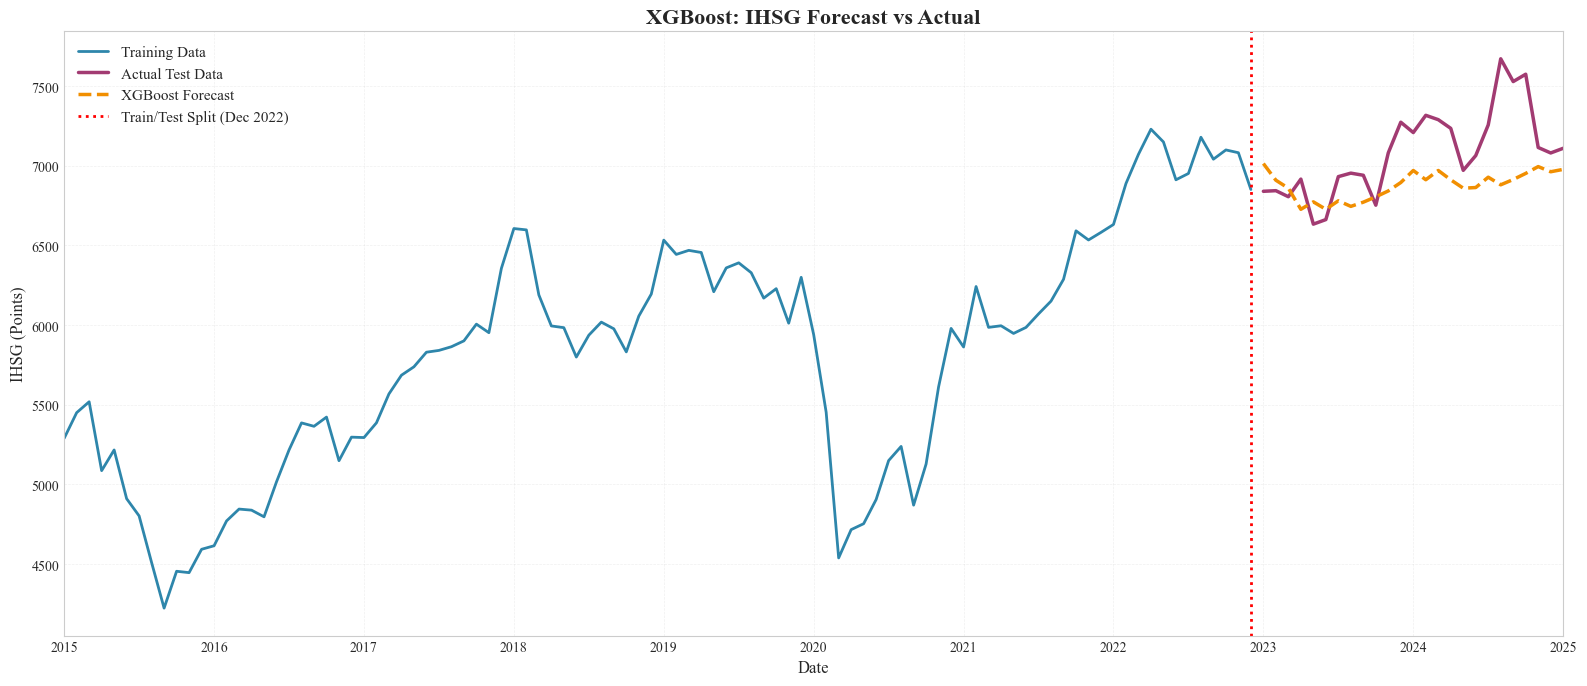

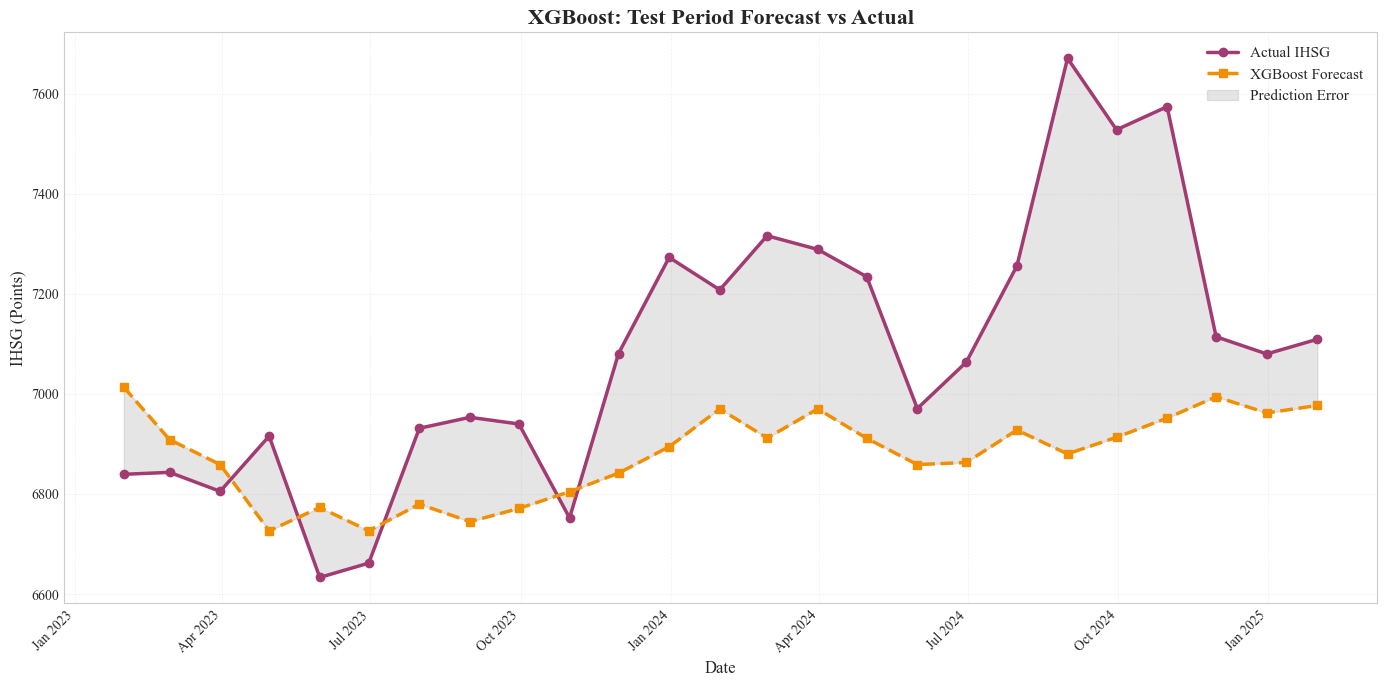

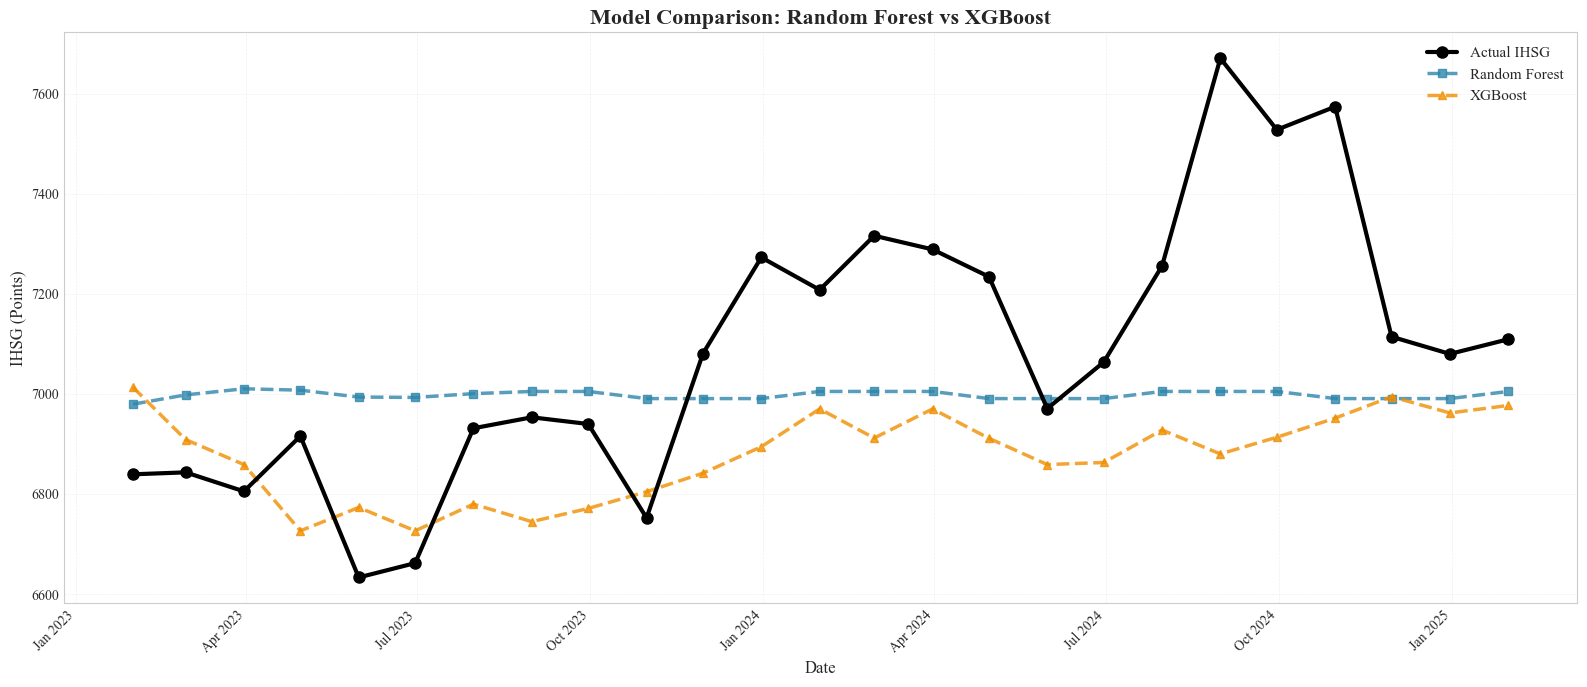

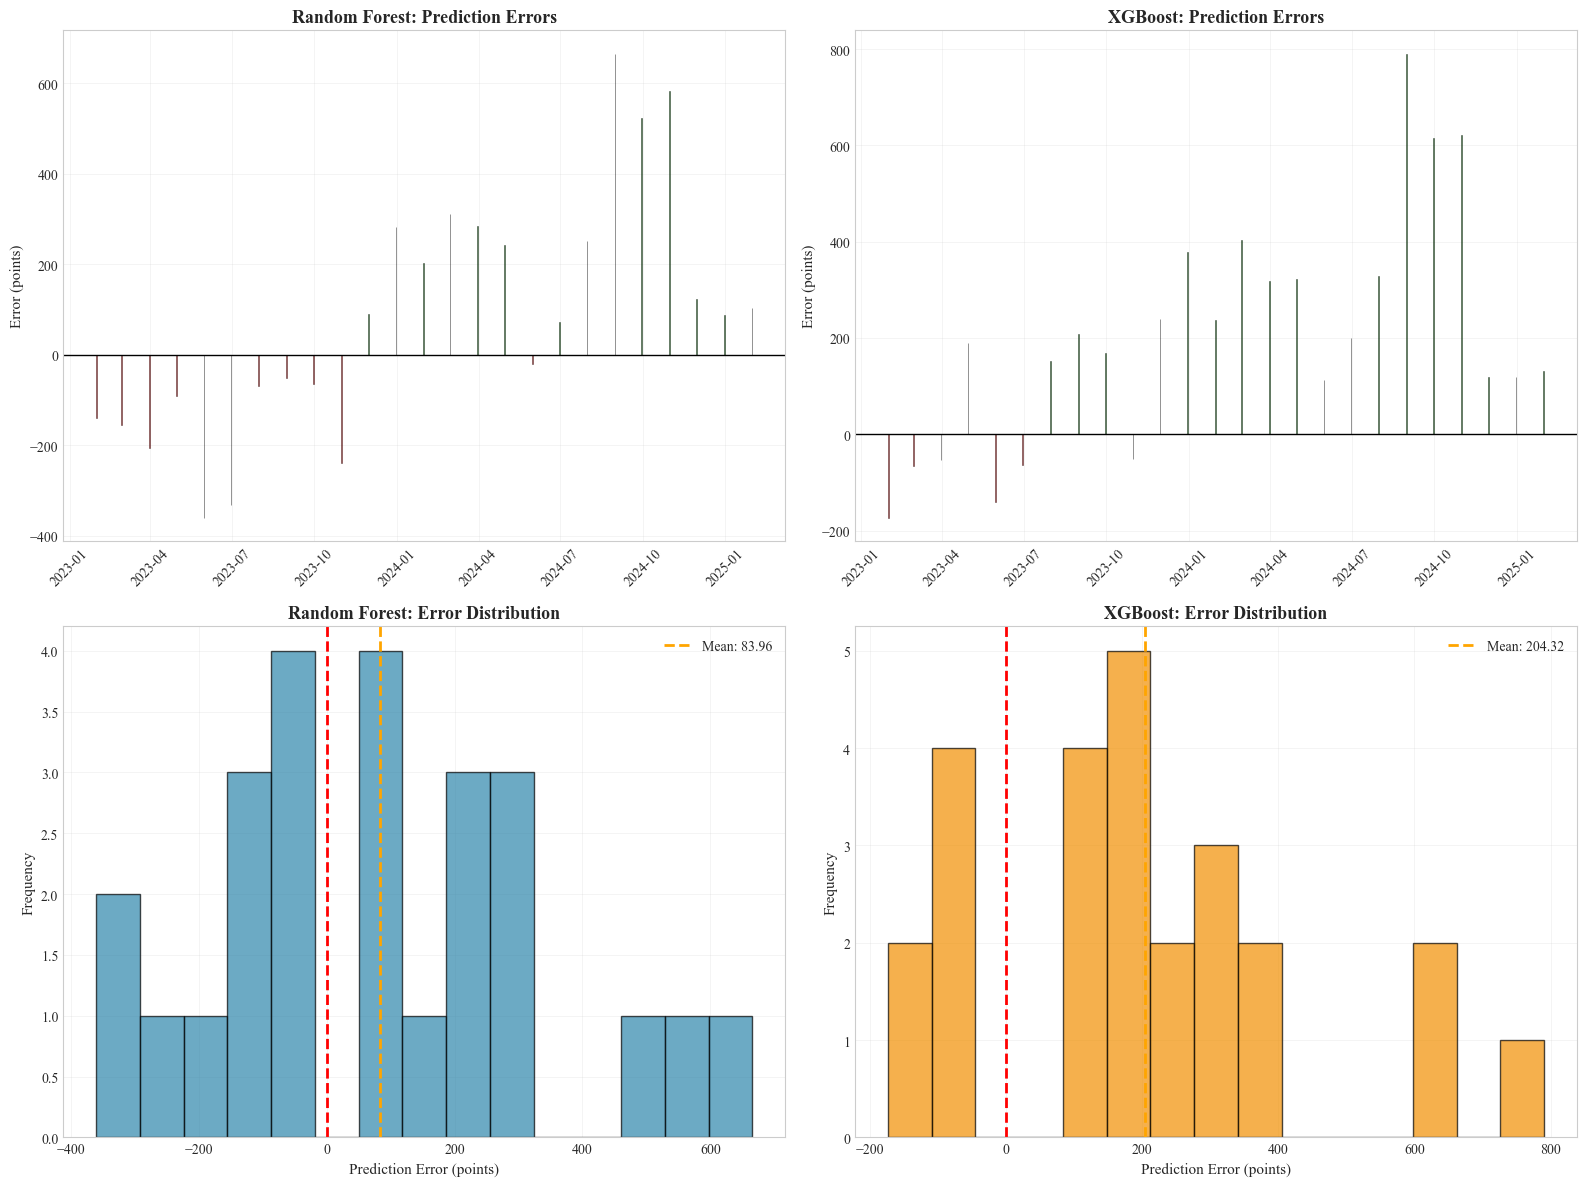

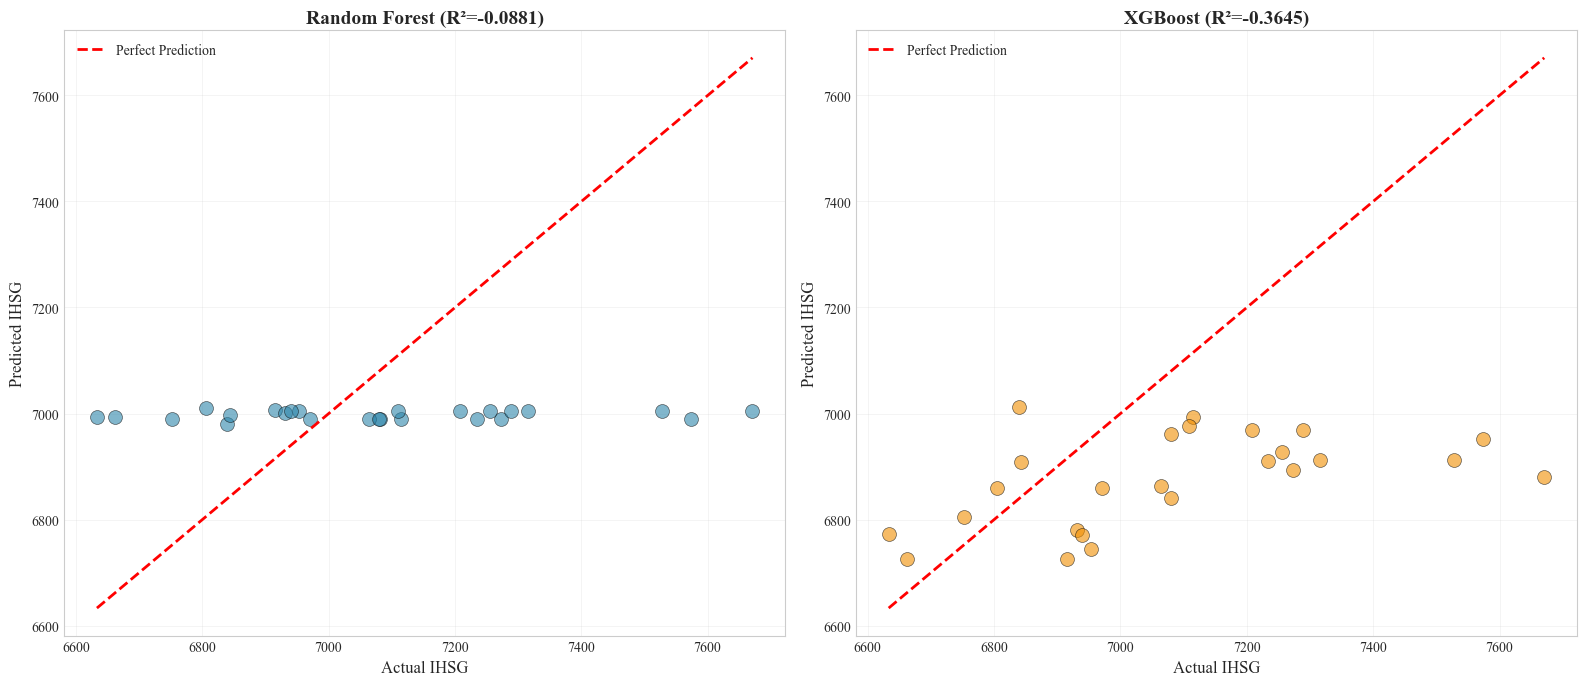

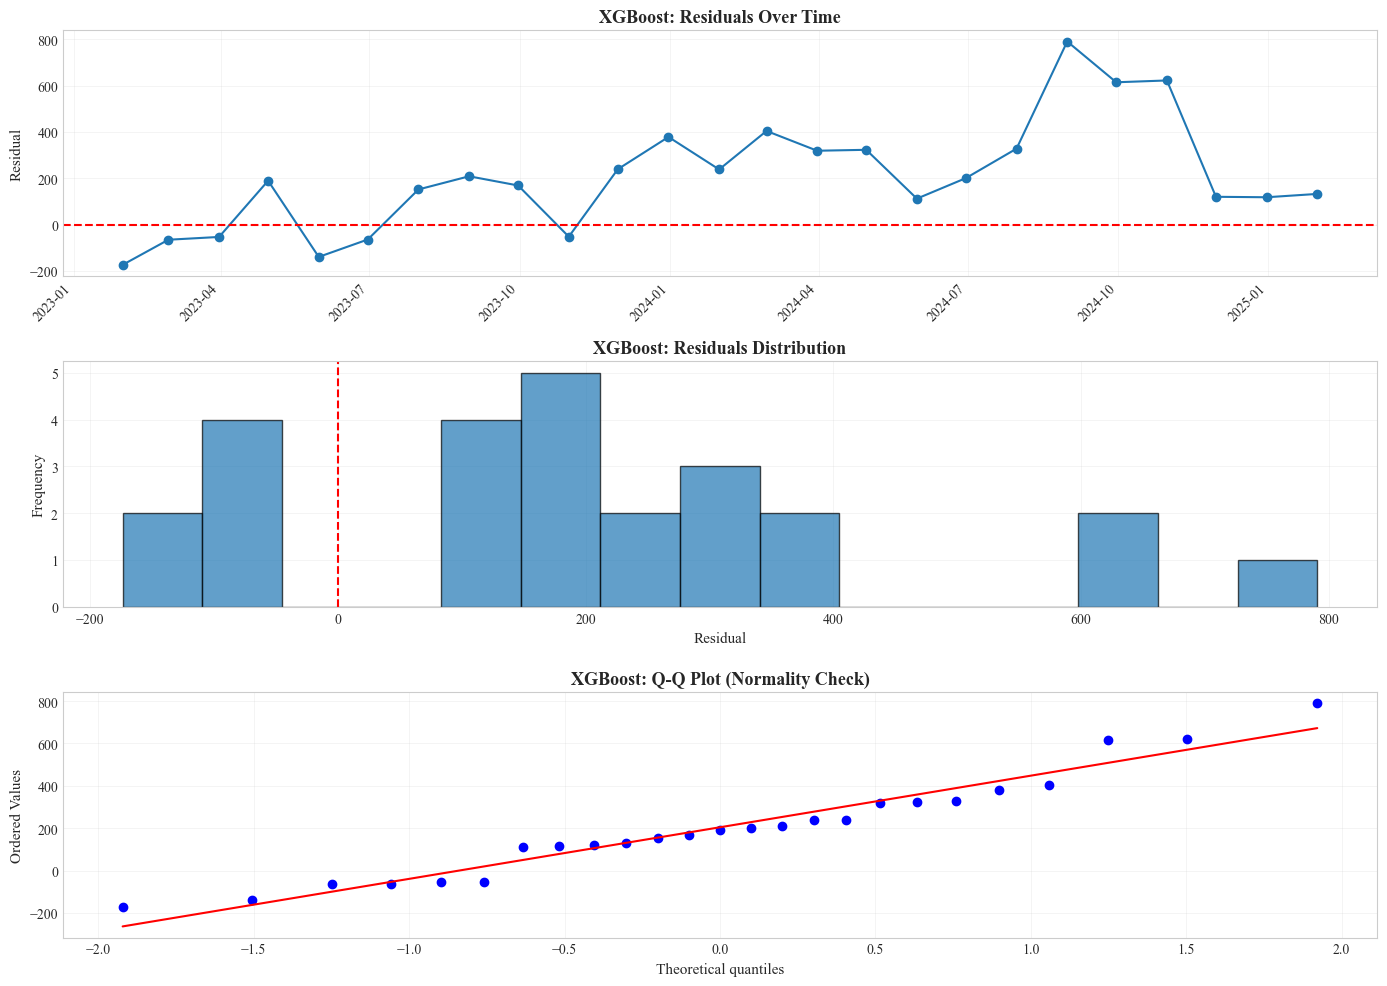


XGBOOST RESIDUAL DIAGNOSTICS
Mean Residual: 204.3250 (should be ~0)
Std Residual:  234.3910

Shapiro-Wilk Test (Normality):
  Statistic: 0.9493, p-value: 0.2412
  ✓ Residuals are normally distributed

RESULTS SAVED
✓ model_comparison_rf_vs_xgb.csv
✓ xgboost_predictions.csv

✅ XGBoost analysis complete!


In [46]:
# =====================================================
# XGBOOST MODEL - COMPLETE ANALYSIS
# =====================================================

# =====================================================
# 1. MODEL PERFORMANCE EVALUATION
# =====================================================
from darts.metrics import rmse, mae, mape, smape, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Inverse transform to original scale
forecast_xgb_original = scaler_ihsg.inverse_transform(forecast_xgb)
test_original = scaler_ihsg.inverse_transform(ihsg_test_scaled)

print("="*70)
print("XGBOOST MODEL PERFORMANCE METRICS (Original Scale)")
print("="*70)

# Calculate metrics
metrics_xgb = {
    'RMSE': rmse(test_original, forecast_xgb_original),
    'MAE': mae(test_original, forecast_xgb_original),
    'MAPE': mape(test_original, forecast_xgb_original),
    'sMAPE': smape(test_original, forecast_xgb_original),
    'R²': r2_score(test_original, forecast_xgb_original)
}

for metric, value in metrics_xgb.items():
    if metric in ['RMSE', 'MAE']:
        print(f"{metric:8s}: {value:>10.2f} points")
    elif metric in ['MAPE', 'sMAPE']:
        print(f"{metric:8s}: {value:>10.4f}%")
    else:
        print(f"{metric:8s}: {value:>10.4f}")

# Add context
avg_ihsg = test_original.values().mean()
print(f"\nAverage IHSG in test period: {avg_ihsg:.2f}")
print(f"RMSE as % of avg IHSG: {(metrics_xgb['RMSE']/avg_ihsg)*100:.2f}%")
print(f"MAE as % of avg IHSG:  {(metrics_xgb['MAE']/avg_ihsg)*100:.2f}%")

# =====================================================
# 2. DIRECTIONAL ACCURACY
# =====================================================
print("\n" + "="*70)
print("DIRECTIONAL ACCURACY ANALYSIS")
print("="*70)

actual_values = test_original.values().flatten()
pred_values_xgb = forecast_xgb_original.values().flatten()

# Calculate returns
actual_returns = np.diff(actual_values)
pred_returns_xgb = np.diff(pred_values_xgb)

# Directional accuracy
direction_correct_xgb = np.sum((actual_returns > 0) == (pred_returns_xgb > 0))
directional_accuracy_xgb = direction_correct_xgb / len(actual_returns) * 100

print(f"Directional Accuracy: {directional_accuracy_xgb:.2f}%")
print(f"(Baseline random guess: 50%)")
print(f"Correct predictions: {direction_correct_xgb}/{len(actual_returns)}")

# =====================================================
# 3. MODEL COMPARISON: XGBoost vs Random Forest
# =====================================================
print("\n" + "="*70)
print("MODEL COMPARISON: XGBoost vs Random Forest")
print("="*70)

comparison_df = pd.DataFrame({
    'Metric': ['MAPE (%)', 'RMSE (points)', 'MAE (points)', 'sMAPE (%)', 'R²', 'Directional Acc (%)'],
    'Random Forest': [
        metrics['MAPE'],
        metrics['RMSE'],
        metrics['MAE'],
        metrics['sMAPE'],
        metrics['R²'],
        directional_accuracy
    ],
    'XGBoost': [
        metrics_xgb['MAPE'],
        metrics_xgb['RMSE'],
        metrics_xgb['MAE'],
        metrics_xgb['sMAPE'],
        metrics_xgb['R²'],
        directional_accuracy_xgb
    ]
})

# Add winner column
comparison_df['Winner'] = comparison_df.apply(
    lambda row: 'RF' if (
        (row.name in [0, 1, 2, 3] and row['Random Forest'] < row['XGBoost']) or
        (row.name in [4, 5] and row['Random Forest'] > row['XGBoost'])
    ) else 'XGB' if (
        (row.name in [0, 1, 2, 3] and row['XGBoost'] < row['Random Forest']) or
        (row.name in [4, 5] and row['XGBoost'] > row['Random Forest'])
    ) else 'Tie',
    axis=1
)

print(comparison_df.to_string(index=False))

# Count wins
rf_wins = (comparison_df['Winner'] == 'RF').sum()
xgb_wins = (comparison_df['Winner'] == 'XGB').sum()
ties = (comparison_df['Winner'] == 'Tie').sum()

print(f"\n📊 Score: RF: {rf_wins} | XGB: {xgb_wins} | Tie: {ties}")

# Determine overall winner
if rf_wins > xgb_wins:
    print(f"🏆 Overall Winner: Random Forest")
elif xgb_wins > rf_wins:
    print(f"🏆 Overall Winner: XGBoost")
else:
    print(f"🤝 Models are equally competitive")

# =====================================================
# 4. VISUALIZATION: XGBoost Forecast vs Actual
# =====================================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Plot 1: Complete timeline
plt.figure(figsize=(16, 7))

train_original = scaler_ihsg.inverse_transform(ihsg_train_scaled)
train_original.plot(label="Training Data", color='#2E86AB', linewidth=2)
test_original.plot(label="Actual Test Data", color='#A23B72', linewidth=2.5)
forecast_xgb_original.plot(label="XGBoost Forecast", color='#F18F01', linewidth=2.5, linestyle='--')

split_date = train_original.end_time()
plt.axvline(x=split_date, color='red', linestyle=':', linewidth=2, 
            label=f'Train/Test Split ({split_date.strftime("%b %Y")})')

plt.title('XGBoost: IHSG Forecast vs Actual', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('IHSG (Points)', fontsize=12)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Plot 2: Test period only (zoomed)
plt.figure(figsize=(14, 7))

test_dates = test_original.time_index

plt.plot(test_dates, actual_values, marker='o', markersize=6, 
         linewidth=2.5, color='#A23B72', label='Actual IHSG', linestyle='-')
plt.plot(test_dates, pred_values_xgb, marker='s', markersize=6, 
         linewidth=2.5, color='#F18F01', label='XGBoost Forecast', linestyle='--')

plt.fill_between(test_dates, actual_values, pred_values_xgb, 
                 alpha=0.2, color='gray', label='Prediction Error')

plt.title('XGBoost: Test Period Forecast vs Actual', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('IHSG (Points)', fontsize=12)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# =====================================================
# 5. SIDE-BY-SIDE MODEL COMPARISON PLOT
# =====================================================
plt.figure(figsize=(16, 7))

# Get RF forecast
forecast_rf_original = scaler_ihsg.inverse_transform(forecast)
pred_values_rf = forecast_rf_original.values().flatten()

plt.plot(test_dates, actual_values, marker='o', markersize=8, 
         linewidth=3, color='black', label='Actual IHSG', zorder=3)
plt.plot(test_dates, pred_values_rf, marker='s', markersize=6, 
         linewidth=2.5, color='#2E86AB', label='Random Forest', linestyle='--', alpha=0.8)
plt.plot(test_dates, pred_values_xgb, marker='^', markersize=6, 
         linewidth=2.5, color='#F18F01', label='XGBoost', linestyle='--', alpha=0.8)

plt.title('Model Comparison: Random Forest vs XGBoost', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('IHSG (Points)', fontsize=12)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# =====================================================
# 6. ERROR ANALYSIS COMPARISON
# =====================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Errors
errors_rf = actual_values - pred_values_rf
errors_xgb = actual_values - pred_values_xgb

# Plot 1: RF Errors over time
axes[0, 0].bar(test_dates, errors_rf, 
               color=['green' if e > 0 else 'red' for e in errors_rf],
               alpha=0.6, edgecolor='black', linewidth=0.5)
axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0, 0].set_title('Random Forest: Prediction Errors', fontweight='bold')
axes[0, 0].set_ylabel('Error (points)')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: XGB Errors over time
axes[0, 1].bar(test_dates, errors_xgb,
               color=['green' if e > 0 else 'red' for e in errors_xgb],
               alpha=0.6, edgecolor='black', linewidth=0.5)
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0, 1].set_title('XGBoost: Prediction Errors', fontweight='bold')
axes[0, 1].set_ylabel('Error (points)')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: RF Error distribution
axes[1, 0].hist(errors_rf, bins=15, edgecolor='black', alpha=0.7, color='#2E86AB')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].axvline(x=errors_rf.mean(), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {errors_rf.mean():.2f}')
axes[1, 0].set_title('Random Forest: Error Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Prediction Error (points)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: XGB Error distribution
axes[1, 1].hist(errors_xgb, bins=15, edgecolor='black', alpha=0.7, color='#F18F01')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=errors_xgb.mean(), color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {errors_xgb.mean():.2f}')
axes[1, 1].set_title('XGBoost: Error Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Prediction Error (points)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# =====================================================
# 7. SCATTER PLOTS COMPARISON
# =====================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# RF Scatter
axes[0].scatter(actual_values, pred_values_rf, alpha=0.6, s=100, 
                color='#2E86AB', edgecolors='black', linewidth=0.5)
min_val = min(actual_values.min(), pred_values_rf.min())
max_val = max(actual_values.max(), pred_values_rf.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, 
             label='Perfect Prediction')
axes[0].set_xlabel('Actual IHSG', fontsize=12)
axes[0].set_ylabel('Predicted IHSG', fontsize=12)
axes[0].set_title(f'Random Forest (R²={metrics["R²"]:.4f})', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# XGB Scatter
axes[1].scatter(actual_values, pred_values_xgb, alpha=0.6, s=100, 
                color='#F18F01', edgecolors='black', linewidth=0.5)
min_val = min(actual_values.min(), pred_values_xgb.min())
max_val = max(actual_values.max(), pred_values_xgb.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, 
             label='Perfect Prediction')
axes[1].set_xlabel('Actual IHSG', fontsize=12)
axes[1].set_ylabel('Predicted IHSG', fontsize=12)
axes[1].set_title(f'XGBoost (R²={metrics_xgb["R²"]:.4f})', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =====================================================
# 8. RESIDUAL ANALYSIS - XGBoost
# =====================================================
from scipy import stats

residuals_xgb = errors_xgb

plt.figure(figsize=(14, 10))

# Residuals over time
plt.subplot(3, 1, 1)
plt.plot(test_dates, residuals_xgb, marker='o')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('XGBoost: Residuals Over Time', fontweight='bold')
plt.ylabel('Residual')
plt.grid(True)
plt.xticks(rotation=45, ha='right')

# Residuals distribution
plt.subplot(3, 1, 2)
plt.hist(residuals_xgb, bins=15, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('XGBoost: Residuals Distribution', fontweight='bold')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)

# Q-Q plot
plt.subplot(3, 1, 3)
stats.probplot(residuals_xgb, dist="norm", plot=plt)
plt.title('XGBoost: Q-Q Plot (Normality Check)', fontweight='bold')
plt.grid(True)

plt.tight_layout()
plt.show()

# Statistical tests
shapiro_stat_xgb, shapiro_p_xgb = stats.shapiro(residuals_xgb)
jb_stat_xgb, jb_p_xgb = stats.jarque_bera(residuals_xgb)

print("\n" + "="*70)
print("XGBOOST RESIDUAL DIAGNOSTICS")
print("="*70)
print(f"Mean Residual: {np.mean(residuals_xgb):.4f} (should be ~0)")
print(f"Std Residual:  {np.std(residuals_xgb):.4f}")
print(f"\nShapiro-Wilk Test (Normality):")
print(f"  Statistic: {shapiro_stat_xgb:.4f}, p-value: {shapiro_p_xgb:.4f}")
print(f"  {'✓ Residuals are normally distributed' if shapiro_p_xgb > 0.05 else '✗ Residuals not normal'}")

# =====================================================
# 9. SAVE RESULTS
# =====================================================
# Save comparison results
comparison_df.to_csv('model_comparison_rf_vs_xgb.csv', index=False)

# Save XGBoost predictions
xgb_results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': actual_values,
    'Predicted': pred_values_xgb,
    'Error': errors_xgb,
    'Absolute_Error': np.abs(errors_xgb),
    'Percentage_Error': np.abs(errors_xgb / actual_values) * 100
})
xgb_results_df.to_csv('xgboost_predictions.csv', index=False)

print("\n" + "="*70)
print("RESULTS SAVED")
print("="*70)
print("✓ model_comparison_rf_vs_xgb.csv")
print("✓ xgboost_predictions.csv")

print("\n✅ XGBoost analysis complete!")

In [47]:
# =====================================================
# FINAL COMPREHENSIVE SUMMARY - UPDATED WITH XGBoost
# =====================================================
print("\n" + "="*70)
print("HASIL PENELITIAN MODEL 1: IHSG DENGAN VARIABEL MAKROEKONOMI")
print("="*70)

# Data Information (sama seperti sebelumnya)
print("\n📊 DATA:")
print(f"   • Periode Data     : {df_clean['Date'].min().strftime('%B %Y')} - {df_clean['Date'].max().strftime('%B %Y')}")
print(f"   • Total Observasi  : {len(df_clean)} bulan")
print(f"   • Train/Test Split : {train_ratio*100:.0f}% / {(1-train_ratio)*100:.0f}%")
print(f"   • Train Period     : {ihsg_train.start_time().strftime('%B %Y')} - {ihsg_train.end_time().strftime('%B %Y')} ({len(ihsg_train)} obs)")
print(f"   • Test Period      : {ihsg_test.start_time().strftime('%B %Y')} - {ihsg_test.end_time().strftime('%B %Y')} ({len(ihsg_test)} obs)")

# Target & Covariates (sama)
print("\n🎯 TARGET:")
print(f"   • Variabel Target  : IHSG (Indeks Harga Saham Gabungan)")

print("\n📈 COVARIATES (Variabel Makroekonomi):")
covariate_cols = ['Inflation_YoY', 'M2_YoY', 'USDIDR', 'BI_Rate', 'NPL_Ratio']
for i, col in enumerate(covariate_cols, 1):
    print(f"   {i}. {col}")

# MODEL COMPARISON TABLE
print("\n🤖 MODEL COMPARISON:")
print("="*70)
print(f"{'Metric':<25} {'Random Forest':>15} {'XGBoost':>15} {'Winner':>10}")
print("-"*70)
print(f"{'MAPE (%)':<25} {metrics['MAPE']:>15.4f} {metrics_xgb['MAPE']:>15.4f} {'RF' if metrics['MAPE'] < metrics_xgb['MAPE'] else 'XGB':>10}")
print(f"{'RMSE (points)':<25} {metrics['RMSE']:>15.2f} {metrics_xgb['RMSE']:>15.2f} {'RF' if metrics['RMSE'] < metrics_xgb['RMSE'] else 'XGB':>10}")
print(f"{'MAE (points)':<25} {metrics['MAE']:>15.2f} {metrics_xgb['MAE']:>15.2f} {'RF' if metrics['MAE'] < metrics_xgb['MAE'] else 'XGB':>10}")
print(f"{'R²':<25} {metrics['R²']:>15.4f} {metrics_xgb['R²']:>15.4f} {'RF' if metrics['R²'] > metrics_xgb['R²'] else 'XGB':>10}")
print(f"{'Directional Acc (%)':<25} {directional_accuracy:>15.2f} {directional_accuracy_xgb:>15.2f} {'RF' if directional_accuracy > directional_accuracy_xgb else 'XGB':>10}")

# Determine best model
if metrics['MAPE'] < metrics_xgb['MAPE']:
    best_model_name = "Random Forest"
    best_metrics = metrics
    best_dir_acc = directional_accuracy
else:
    best_model_name = "XGBoost"
    best_metrics = metrics_xgb
    best_dir_acc = directional_accuracy_xgb

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   • MAPE: {best_metrics['MAPE']:.4f}%")
print(f"   • R²: {best_metrics['R²']:.4f}")

# Best Hyperparameters for both models
print(f"\n⚙️ BEST HYPERPARAMETERS:")
print(f"\nRandom Forest:")
for param, value in best_params.items():
    print(f"   • {param:<25}: {value}")

print(f"\nXGBoost:")
for param, value in best_params_xgb.items():
    print(f"   • {param:<25}: {value}")

# SHAP Feature Importance
print("\n🔍 FEATURE IMPORTANCE (SHAP - Random Forest):")
print(f"\n   Top 5 Most Important Features:")
for i, row in enumerate(feature_importance_df.head(5).itertuples(), 1):
    pct = (row.Mean_Abs_SHAP / feature_importance_df['Mean_Abs_SHAP'].sum()) * 100
    print(f"   {i}. {row.Feature:<40} : {pct:>5.2f}% [{row.Category}]")

print(f"\n   Category Ranking:")
total_shap = category_importance.sum()
for i, (category, importance) in enumerate(category_importance.items(), 1):
    pct = (importance / total_shap) * 100
    print(f"   {i}. {category:<20} : {pct:>6.2f}%")

# Key Findings
print("\n💡 KEY FINDINGS:")
print(f"   1. {best_model_name} outperforms with {best_metrics['MAPE']:.2f}% MAPE")
print(f"   2. Both models achieve >50% directional accuracy (RF: {directional_accuracy:.1f}%, XGB: {directional_accuracy_xgb:.1f}%)")
print(f"   3. {category_importance.index[0]} is the most influential category")
print(f"   4. Model explains {best_metrics['R²']*100:.1f}% of IHSG variance")

# Footer
print("\n" + "="*70)
print(f"Best Model: {best_model_name}")
print("Horizon: 1 month ahead forecast")
print("Source: Author's calculation, 2025")
print("="*70)


HASIL PENELITIAN MODEL 1: IHSG DENGAN VARIABEL MAKROEKONOMI

📊 DATA:
   • Periode Data     : January 2015 - January 2025
   • Total Observasi  : 121 bulan
   • Train/Test Split : 80% / 20%
   • Train Period     : January 2015 - December 2022 (96 obs)
   • Test Period      : January 2023 - January 2025 (25 obs)

🎯 TARGET:
   • Variabel Target  : IHSG (Indeks Harga Saham Gabungan)

📈 COVARIATES (Variabel Makroekonomi):
   1. Inflation_YoY
   2. M2_YoY
   3. USDIDR
   4. BI_Rate
   5. NPL_Ratio

🤖 MODEL COMPARISON:
Metric                      Random Forest         XGBoost     Winner
----------------------------------------------------------------------
MAPE (%)                           3.0925          3.4242         RF
RMSE (points)                      277.67          310.95         RF
MAE (points)                       222.17          248.30         RF
R²                                -0.0881         -0.3645         RF
Directional Acc (%)                 58.33           45.83        